# Example 4: `intrinsic` applied to MNIST on SimCLR with resize and crop + rotation (0,180)

In this example, we apply `intrinsic` to data representations of MNIST images obtained with SimCLR.

SimCLR transformations include:



```
transforms.Compose([
            transforms.RandomResizedCrop(size=size, scale=(0.2, 1.0)),
            transforms.RandomRotation(degrees=(0, 180)),
            transforms.RandomApply([transforms.ColorJitter(brightness=0.5,
                                        contrast=0.5,
                                        saturation=0.5,
                                        hue=0.1)], p=0.8),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.1307], std=[0.3081])
        ])

```

SimCLR loss on train: 0.56



Embeddings are available at: [google drive link](https://drive.google.com/drive/folders/1UfEKGwrr02EP6ssWp4P0tiL-xtGm3pqV?usp=sharing)
\
We save embeddings on layers (see the full scheme below): `layer2_block2`, `layer3_block2`, `layer1_block2`, `layer4_block2`.

We calculate on each epoch for each saved layer:
*   Intrinsic dimension (by MLE, TwoNN)
*   Magnitude
*   Curvature
*   Persistence diagrams
*   Total persistence




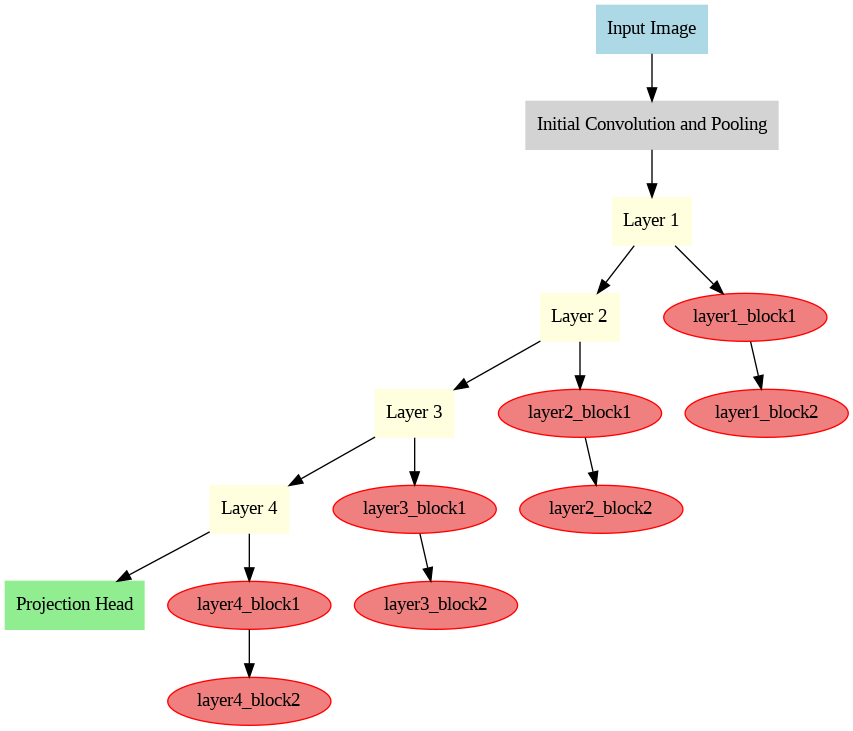

In [1]:
from IPython.display import Image
Image(filename='/content/simclr_full_diagram.png')

## Imports and installs

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import numpy as np
import os
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [ ]:
# Import Google Drive and mount it
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## SimCLR

In [ ]:
save_path = '/content/drive/My Drive/embeddings_SimCLR_MNIST_2'
os.makedirs(save_path, exist_ok=True)

In [ ]:
class SimCLR(nn.Module):
    def __init__(self, base_model, projection_dim=128):
        super(SimCLR, self).__init__()
        self.base_model = base_model
        self.feature_dim = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()
        self.projection_head = nn.Sequential(
            nn.Linear(self.feature_dim, self.feature_dim),
            nn.ReLU(),
            nn.Linear(self.feature_dim, projection_dim)
        )
        self._init_hooks()
        self._init_weights()

    def _init_hooks(self):
        self.layer_outputs = {}
        def get_activation(name):
            def hook(model, input, output):
                self.layer_outputs[name] = output
            return hook

        # Register hooks for desired layers
        self.base_model.layer1[1].register_forward_hook(get_activation('layer1_block2'))
        self.base_model.layer2[1].register_forward_hook(get_activation('layer2_block2'))
        self.base_model.layer3[1].register_forward_hook(get_activation('layer3_block2'))
        self.base_model.layer4[1].register_forward_hook(get_activation('layer4_block2'))
        self.base_model.avgpool.register_forward_hook(get_activation('avgpool'))

    def _init_weights(self):
        for m in self.projection_head.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        self.layer_outputs = {}  # Reset stored outputs
        features = self.base_model(x)
        projections = self.projection_head(features)
        return projections, features

class SimCLRTransform:
    def __init__(self, size):
        self.train_transform = transforms.Compose([
            transforms.RandomResizedCrop(size=size, scale=(0.2, 1.0)),
            # transforms.RandomHorizontalFlip(),
            # transforms.RandomVerticalFlip(),
            transforms.RandomRotation(degrees=(0, 180)),
            # transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=10)], p=0.8),
            transforms.RandomApply([transforms.ColorJitter(brightness=0.5,
                                        contrast=0.5,
                                        saturation=0.5,
                                        hue=0.1)], p=0.8),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.1307], std=[0.3081])  # Mean and std for MNIST
        ])

    def __call__(self, x):
        return self.train_transform(x), self.train_transform(x)

def get_dataset(dataset_name, batch_size):
    if dataset_name == "MNIST":
        transform = SimCLRTransform(size=28)
        train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    elif dataset_name == "EMNIST":
        transform = SimCLRTransform(size=28, scale=(0.2, 1.0))
        train_dataset = datasets.EMNIST(root='./data', split='balanced', train=True, transform=transform, download=True)
    elif dataset_name == "COIL100":
        transform = SimCLRTransform(size=128)
        train_dataset = datasets.ImageFolder(root='./coil-100', transform=transform)
    else:
        raise ValueError("Unsupported dataset: {}".format(dataset_name))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    return train_loader

class NTXentLoss(nn.Module):
    def __init__(self, batch_size, temperature):
        super(NTXentLoss, self).__init__()
        self.batch_size = batch_size
        self.temperature = temperature
        self.criterion = nn.CrossEntropyLoss(reduction="sum")


    def forward(self, z_i, z_j):
        # Concatenate the two sets of embeddings
        z = torch.cat((z_i, z_j), dim=0)

        # Compute the similarity matrix
        sim = torch.matmul(z, z.T) / self.temperature

        # Create a mask to remove the diagonal elements (self-similarity)
        N = 2 * self.batch_size
        mask = torch.eye(N, device=sim.device).bool()
        sim = sim.masked_select(~mask).view(N, N-1)

        # Create the labels for the positive pairs
        labels = torch.cat([torch.arange(self.batch_size) for _ in range(2)], dim=0)
        labels = (labels.unsqueeze(1) == labels.unsqueeze(0)).float().to(sim.device)
        labels = labels.masked_select(~mask).view(N, N-1)

        # Compute the loss
        loss = self.criterion(sim, labels)
        loss /= N

        return loss

def train_simclr(model, data_loader, optimizer, criterion, device, epochs, save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)

    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        epoch_embeddings = {f'layer{i}_block{j}': [] for i in range(1, 5) for j in range(2, 3)}
        epoch_embeddings['final'] = []
        progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for (x_i, x_j), target in progress_bar:
            x_i = x_i.to(device)
            x_j = x_j.to(device)
            target = target.to(device)

            optimizer.zero_grad()
            z_i, features_i = model(x_i)
            z_j, features_j = model(x_j)

            loss = criterion(z_i, z_j)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

            for i in range(1, 5):
                for j in range(2, 3):
                    layer_name = f'layer{i}_block{j}'
                    if layer_name in model.layer_outputs:
                        epoch_embeddings[layer_name].append(model.layer_outputs[layer_name].cpu().detach().numpy())

            if 'avgpool' in model.layer_outputs:
                epoch_embeddings['final'].append(model.layer_outputs['avgpool'].cpu().detach().numpy())

        if epoch % 5 == 0:
          for i in range(1, 5):
              for j in range(2, 3):
                  layer_name = f'layer{i}_block{j}'
                  if epoch_embeddings[layer_name]:
                      np.save(os.path.join(save_path, f'epoch_{epoch+1}_{layer_name}_embeddings.npy'), np.concatenate(epoch_embeddings[layer_name], axis=0))

          if epoch_embeddings['final']:
              np.save(os.path.join(save_path, f'epoch_{epoch+1}_final_embeddings.npy'), np.concatenate(epoch_embeddings['final'], axis=0))

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(data_loader)}')


In [ ]:
num_epochs = 51
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modify the ResNet model to accept grayscale input (1 channel instead of 3)
base_model = models.resnet18(weights=None)
base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
simclr_model = SimCLR(base_model=base_model).to(device)

optimizer = optim.Adam(simclr_model.parameters(), lr=3e-4)
criterion = NTXentLoss(batch_size=20, temperature=0.5)

train_loader = get_dataset("MNIST", batch_size=20)
train_simclr(simclr_model, train_loader, optimizer, criterion, device, epochs=num_epochs, save_path=save_path)


Epoch 1/51: 100%|██████████| 3000/3000 [01:28<00:00, 33.82it/s, loss=2.15]


Epoch [1/51], Loss: 3.41882059665521


Epoch 2/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.32it/s, loss=2.29]


Epoch [2/51], Loss: 2.2700106380780536


Epoch 3/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.56it/s, loss=1.88]


Epoch [3/51], Loss: 1.8422543068528174


Epoch 4/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.55it/s, loss=1.02]


Epoch [4/51], Loss: 1.5758508717219035


Epoch 5/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.48it/s, loss=1.42]


Epoch [5/51], Loss: 1.4432500590880712


Epoch 6/51: 100%|██████████| 3000/3000 [01:31<00:00, 32.65it/s, loss=1.22]


Epoch [6/51], Loss: 1.316148738135894


Epoch 7/51: 100%|██████████| 3000/3000 [01:33<00:00, 32.26it/s, loss=0.929]


Epoch [7/51], Loss: 1.233374643256267


Epoch 8/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.50it/s, loss=0.82]


Epoch [8/51], Loss: 1.1696878644625346


Epoch 9/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.39it/s, loss=1.08]


Epoch [9/51], Loss: 1.105866922368606


Epoch 10/51: 100%|██████████| 3000/3000 [01:31<00:00, 32.68it/s, loss=1.08]


Epoch [10/51], Loss: 1.050720113058885


Epoch 11/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.35it/s, loss=1.45]


Epoch [11/51], Loss: 1.0196921125749747


Epoch 12/51: 100%|██████████| 3000/3000 [01:33<00:00, 32.05it/s, loss=0.576]


Epoch [12/51], Loss: 0.9738367826044559


Epoch 13/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.56it/s, loss=0.75]


Epoch [13/51], Loss: 0.9412632880310218


Epoch 14/51: 100%|██████████| 3000/3000 [01:31<00:00, 32.81it/s, loss=0.475]


Epoch [14/51], Loss: 0.9092555525700251


Epoch 15/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.43it/s, loss=1.06]


Epoch [15/51], Loss: 0.8825739078819752


Epoch 16/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.55it/s, loss=0.297]


Epoch [16/51], Loss: 0.8605135415333013


Epoch 17/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.31it/s, loss=0.806]


Epoch [17/51], Loss: 0.8382674525529146


Epoch 18/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.44it/s, loss=0.225]


Epoch [18/51], Loss: 0.8185784200479587


Epoch 19/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.27it/s, loss=0.939]


Epoch [19/51], Loss: 0.8105690424293279


Epoch 20/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.50it/s, loss=0.7]


Epoch [20/51], Loss: 0.792391484628121


Epoch 21/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.53it/s, loss=1.26]


Epoch [21/51], Loss: 0.7632137688919902


Epoch 22/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.34it/s, loss=2.16]


Epoch [22/51], Loss: 0.7613293043896556


Epoch 23/51: 100%|██████████| 3000/3000 [01:33<00:00, 31.92it/s, loss=1.21]


Epoch [23/51], Loss: 0.750934878009061


Epoch 24/51: 100%|██████████| 3000/3000 [01:31<00:00, 32.95it/s, loss=0.665]


Epoch [24/51], Loss: 0.7381908378005028


Epoch 25/51: 100%|██████████| 3000/3000 [01:33<00:00, 32.15it/s, loss=0.724]


Epoch [25/51], Loss: 0.7206575640564163


Epoch 26/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.52it/s, loss=1.08]


Epoch [26/51], Loss: 0.7124800973472496


Epoch 27/51: 100%|██████████| 3000/3000 [01:34<00:00, 31.85it/s, loss=1.65]


Epoch [27/51], Loss: 0.7050593449038763


Epoch 28/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.28it/s, loss=0.477]


Epoch [28/51], Loss: 0.6966809624383847


Epoch 29/51: 100%|██████████| 3000/3000 [01:34<00:00, 31.80it/s, loss=1.22]


Epoch [29/51], Loss: 0.6904319468699396


Epoch 30/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.39it/s, loss=0.648]


Epoch [30/51], Loss: 0.6772582458555698


Epoch 31/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.39it/s, loss=1.59]


Epoch [31/51], Loss: 0.6710334747110804


Epoch 32/51: 100%|██████████| 3000/3000 [01:34<00:00, 31.79it/s, loss=0.318]


Epoch [32/51], Loss: 0.6631099969868859


Epoch 33/51: 100%|██████████| 3000/3000 [01:31<00:00, 32.63it/s, loss=0.219]


Epoch [33/51], Loss: 0.6609898645610859


Epoch 34/51: 100%|██████████| 3000/3000 [01:33<00:00, 31.96it/s, loss=0.361]


Epoch [34/51], Loss: 0.6526301657507817


Epoch 35/51: 100%|██████████| 3000/3000 [01:34<00:00, 31.84it/s, loss=0.555]


Epoch [35/51], Loss: 0.6439085621324678


Epoch 36/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.57it/s, loss=1.08]


Epoch [36/51], Loss: 0.6395892603956163


Epoch 37/51: 100%|██████████| 3000/3000 [01:33<00:00, 32.12it/s, loss=0.21]


Epoch [37/51], Loss: 0.6402370946059625


Epoch 38/51: 100%|██████████| 3000/3000 [01:33<00:00, 32.20it/s, loss=0.178]


Epoch [38/51], Loss: 0.6230790909367303


Epoch 39/51: 100%|██████████| 3000/3000 [01:33<00:00, 32.26it/s, loss=0.765]


Epoch [39/51], Loss: 0.6261734034400434


Epoch 40/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.36it/s, loss=0.716]


Epoch [40/51], Loss: 0.6204956659773986


Epoch 41/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.30it/s, loss=0.338]


Epoch [41/51], Loss: 0.6127496427794298


Epoch 42/51: 100%|██████████| 3000/3000 [01:33<00:00, 32.10it/s, loss=0.75]


Epoch [42/51], Loss: 0.6068120330478997


Epoch 43/51: 100%|██████████| 3000/3000 [01:31<00:00, 32.80it/s, loss=0.949]


Epoch [43/51], Loss: 0.6015896945446729


Epoch 44/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.30it/s, loss=0.824]


Epoch [44/51], Loss: 0.6053055748318632


Epoch 45/51: 100%|██████████| 3000/3000 [01:33<00:00, 32.25it/s, loss=0.713]


Epoch [45/51], Loss: 0.6003812092381219


Epoch 46/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.29it/s, loss=0.342]


Epoch [46/51], Loss: 0.5874493011888117


Epoch 47/51: 100%|██████████| 3000/3000 [01:33<00:00, 32.13it/s, loss=0.218]


Epoch [47/51], Loss: 0.5813347879101832


Epoch 48/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.35it/s, loss=0.498]


Epoch [48/51], Loss: 0.5791287638607124


Epoch 49/51: 100%|██████████| 3000/3000 [01:33<00:00, 32.18it/s, loss=1.22]


Epoch [49/51], Loss: 0.5782043202091008


Epoch 50/51: 100%|██████████| 3000/3000 [01:33<00:00, 31.98it/s, loss=0.219]


Epoch [50/51], Loss: 0.5708592714847376


Epoch 51/51: 100%|██████████| 3000/3000 [01:32<00:00, 32.43it/s, loss=0.533]


Epoch [51/51], Loss: 0.5621535119693726


In [ ]:
def save_simclr_model(model, optimizer, save_path):
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }, save_path)

In [ ]:
save_path = '/content/simclr/simclr_mnist.pth'
save_simclr_model(simclr_model, optimizer, save_path)

In [ ]:
def load_simclr_model(model, optimizer, load_path):
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    model.to(device)

    return model, optimizer

In [ ]:
load_path =  '/content/simclr/simclr_mnist.pth'
base_model=models.resnet18(pretrained=False)
base_model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
model = SimCLR(base_model=base_model)
optimizer = optim.Adam(model.parameters(), lr=3e-4)
loaded_model, loaded_optimizer = load_simclr_model(model, optimizer, load_path)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
save_path = '/content/drive/My Drive/embeddings_SimCLR_MNIST_2'
os.makedirs(save_path, exist_ok=True)

In [ ]:
def load_embeddings_from_drive(folder_path, epochs):
    embeddings = {}

    for epoch in range(1, epochs + 1, 5):
        epoch_embeddings = {}

        for i in range(1, 5):
            for j in range(2, 3):
                layer_name = f'layer{i}_block{j}'
                file_path = os.path.join(folder_path, f'epoch_{epoch}_{layer_name}_embeddings.npy')
                if os.path.exists(folder_path):
                    epoch_embeddings[layer_name] = np.load(file_path)

        final_file_path = os.path.join(folder_path, f'epoch_{epoch}_final_embeddings.npy')
        if os.path.exists(folder_path):
            epoch_embeddings['final'] = np.load(final_file_path)

        labels_file_path = os.path.join(folder_path, f'epoch_{epoch}_labels.npy')
        if os.path.exists(labels_file_path):
            epoch_embeddings['labels'] = np.load(labels_file_path)

        if epoch_embeddings:
            embeddings[epoch] = epoch_embeddings

    return embeddings

In [ ]:
embeddings = load_embeddings_from_drive(save_path, epochs=21)

for epoch, embs in embeddings.items():
  for layer, emb in embs.items():
    print(f"Epoch: {epoch}, Layer: {layer}, Embedding shape: {emb.shape}")

Epoch: 1, Layer: layer1_block2, Embedding shape: (60000, 64, 7, 7)
Epoch: 1, Layer: layer2_block2, Embedding shape: (60000, 128, 4, 4)
Epoch: 1, Layer: layer3_block2, Embedding shape: (60000, 256, 2, 2)
Epoch: 1, Layer: layer4_block2, Embedding shape: (60000, 512, 1, 1)
Epoch: 1, Layer: final, Embedding shape: (60000, 512, 1, 1)
Epoch: 6, Layer: layer1_block2, Embedding shape: (60000, 64, 7, 7)
Epoch: 6, Layer: layer2_block2, Embedding shape: (60000, 128, 4, 4)
Epoch: 6, Layer: layer3_block2, Embedding shape: (60000, 256, 2, 2)
Epoch: 6, Layer: layer4_block2, Embedding shape: (60000, 512, 1, 1)
Epoch: 6, Layer: final, Embedding shape: (60000, 512, 1, 1)
Epoch: 11, Layer: layer1_block2, Embedding shape: (60000, 64, 7, 7)
Epoch: 11, Layer: layer2_block2, Embedding shape: (60000, 128, 4, 4)
Epoch: 11, Layer: layer3_block2, Embedding shape: (60000, 256, 2, 2)
Epoch: 11, Layer: layer4_block2, Embedding shape: (60000, 512, 1, 1)
Epoch: 11, Layer: final, Embedding shape: (60000, 512, 1, 1)
Ep

In [ ]:
list_embs = []
list_epochs = []
list_layers = []
list_labels = []

for epoch, embs in embeddings.items():
    for layer, emb in embs.items():
        if layer != 'labels' and layer != 'final':  # Skip 'labels' and 'final' keys
            list_embs.append(emb.reshape(emb.shape[0], -1))
            list_epochs.append(epoch)
            list_layers.append(layer)
        else:
          list_labels.append(emb)

total_embeddings = len(list_embs)
print("Total embeddings:", total_embeddings)

Total embeddings: 20


In [ ]:
layers_simclr = list(set(list_layers))
layers_simclr.sort()
layers_simclr

['layer1_block2', 'layer2_block2', 'layer3_block2', 'layer4_block2']

In [ ]:
# Define the ResNet-18 layer structure
layer_structure = {
    'conv1': 1,
    'layer1': 2,
    'layer2': 2,
    'layer3': 2,
    'layer4': 2,
    'avgpool': 1
}

# Calculate total number of layers
total_layers = sum(layer_structure.values())

# Define a function to calculate relative depth and normalize
def calculate_and_normalize_depth(layer_name):
    if 'layer' in layer_name:
        layer_num = int(layer_name[5])  # Extract the layer number (e.g., 'layer1' -> 1)
        block_num = int(layer_name[-1])  # Extract the block number (e.g., 'block2' -> 2)
        # Calculate depth relative to the entire network
        relative_depth = sum(list(layer_structure.values())[:layer_num]) + block_num
    else:
        # For non-layer specific parts like 'avgpool', 'fc', etc.
        relative_depth = sum(list(layer_structure.values())[:-1]) + 1

    # Normalize relative depth to range [0, 1]
    normalized_depth = (relative_depth - 1) / (total_layers - 1)

    return normalized_depth


# Calculate and normalize depths
normalized_depths = [calculate_and_normalize_depth(layer) for layer in layers_simclr]

# Print normalized depths
for layer, norm_depth in zip(layers_simclr, normalized_depths):
    print(f'{layer} normalized depth:', norm_depth)


layer1_block2 normalized depth: 0.2222222222222222
layer2_block2 normalized depth: 0.4444444444444444
layer3_block2 normalized depth: 0.6666666666666666
layer4_block2 normalized depth: 0.8888888888888888


In [ ]:
normalized_depths.sort()

## Predict angle of rotation

In [ ]:
class RotationRegression(nn.Module):
    def __init__(self, feature_dim):
        super(RotationRegression, self).__init__()
        # self.fc = nn.Linear(feature_dim, 1)  # Predicting a single value (angle)
        self.fc = nn.Sequential(
            nn.BatchNorm1d(feature_dim),
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.fc(x)

def train_rotation_regression(model, feature_extractor, data_loader, optimizer, criterion, device, epochs):
    model.train()
    feature_extractor.eval()

    for epoch in range(epochs):
        total_loss = 0.0
        progress_bar = tqdm(data_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for x, angle in progress_bar:
            x = x.to(device)
            angle = angle.to(device).float().unsqueeze(1)

            with torch.no_grad():
                features = feature_extractor(x)
                features = features.view(features.size(0), -1)  # Flatten features

            optimizer.zero_grad()
            outputs = model(features)
            # print(outputs[:2], angle[:2])
            loss = criterion(outputs, angle)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(data_loader)}')

class RotationAngleDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.1307], std=[0.3081])  # Mean and std for MNIST
        ])

    def __getitem__(self, index):
        img, _ = self.dataset[index]
        angle = np.random.uniform(0, 179)
        img = transforms.functional.rotate(img, angle)
        img = self.transform(img)
        return img, angle

    def __len__(self):
        return len(self.dataset)

def get_angle_dataset(dataset_name, batch_size):
    if dataset_name == "MNIST":
        train_dataset = datasets.MNIST(root='./data', train=True, download=True)
    elif dataset_name == "EMNIST":
        train_dataset = datasets.EMNIST(root='./data', split='balanced', train=True, download=True)
    elif dataset_name == "COIL100":
        train_dataset = datasets.ImageFolder(root='./coil-100')
    else:
        raise ValueError("Unsupported dataset: {}".format(dataset_name))

    angle_dataset = RotationAngleDataset(train_dataset)
    train_loader = DataLoader(angle_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    return train_loader

In [ ]:
# Define feature dimension
feature_dim = loaded_model.projection_head[0].in_features

# Train the Rotation Regression Model
num_epochs = 300
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load pretrained SimCLR base model and create a feature extractor
feature_extractor = nn.Sequential(*list(loaded_model.base_model.children())[:-1]).to(device)
feature_extractor.eval()

# Create the rotation regression model
rotation_model = RotationRegression(feature_dim=feature_dim).to(device)

# Only train the regression head
optimizer = optim.Adam(rotation_model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

train_loader = get_angle_dataset("MNIST", batch_size=500)
train_rotation_regression(rotation_model, feature_extractor, train_loader, optimizer, criterion, device, epochs=num_epochs)


Epoch 1/300:   0%|          | 0/120 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Epoch 1/300: 100%|██████████| 120/120 [00:05<00:00, 20.58it/s, loss=2.66e+3]


Epoch [1/300], Loss: 7236.079001871744


Epoch 2/300: 100%|██████████| 120/120 [00:05<00:00, 21.84it/s, loss=1.88e+3]


Epoch [2/300], Loss: 2276.1592274983723


Epoch 3/300: 100%|██████████| 120/120 [00:05<00:00, 21.93it/s, loss=1.72e+3]


Epoch [3/300], Loss: 1975.4771626790364


Epoch 4/300: 100%|██████████| 120/120 [00:05<00:00, 22.48it/s, loss=1.63e+3]


Epoch [4/300], Loss: 1774.2552083333333


Epoch 5/300: 100%|██████████| 120/120 [00:05<00:00, 21.57it/s, loss=1.58e+3]


Epoch [5/300], Loss: 1616.1604370117188


Epoch 6/300: 100%|██████████| 120/120 [00:05<00:00, 22.13it/s, loss=1.67e+3]


Epoch [6/300], Loss: 1564.0828857421875


Epoch 7/300: 100%|██████████| 120/120 [00:05<00:00, 21.78it/s, loss=1.56e+3]


Epoch [7/300], Loss: 1511.2803039550781


Epoch 8/300: 100%|██████████| 120/120 [00:05<00:00, 22.15it/s, loss=1.32e+3]


Epoch [8/300], Loss: 1443.5094818115235


Epoch 9/300: 100%|██████████| 120/120 [00:05<00:00, 22.05it/s, loss=1.46e+3]


Epoch [9/300], Loss: 1400.4924173990885


Epoch 10/300: 100%|██████████| 120/120 [00:05<00:00, 21.82it/s, loss=1.41e+3]


Epoch [10/300], Loss: 1391.0063354492188


Epoch 11/300: 100%|██████████| 120/120 [00:05<00:00, 21.97it/s, loss=1.36e+3]


Epoch [11/300], Loss: 1339.748967997233


Epoch 12/300: 100%|██████████| 120/120 [00:05<00:00, 21.09it/s, loss=1.49e+3]


Epoch [12/300], Loss: 1307.1373494466145


Epoch 13/300: 100%|██████████| 120/120 [00:05<00:00, 21.98it/s, loss=1.24e+3]


Epoch [13/300], Loss: 1301.4405212402344


Epoch 14/300: 100%|██████████| 120/120 [00:05<00:00, 21.48it/s, loss=1.28e+3]


Epoch [14/300], Loss: 1281.780264790853


Epoch 15/300: 100%|██████████| 120/120 [00:05<00:00, 22.31it/s, loss=1.32e+3]


Epoch [15/300], Loss: 1226.8173797607421


Epoch 16/300: 100%|██████████| 120/120 [00:05<00:00, 21.27it/s, loss=1.15e+3]


Epoch [16/300], Loss: 1202.4145375569663


Epoch 17/300: 100%|██████████| 120/120 [00:05<00:00, 22.34it/s, loss=1.25e+3]


Epoch [17/300], Loss: 1196.2780853271483


Epoch 18/300: 100%|██████████| 120/120 [00:05<00:00, 21.87it/s, loss=1.21e+3]


Epoch [18/300], Loss: 1179.4761271158854


Epoch 19/300: 100%|██████████| 120/120 [00:05<00:00, 22.00it/s, loss=1.09e+3]


Epoch [19/300], Loss: 1171.0606541951497


Epoch 20/300: 100%|██████████| 120/120 [00:05<00:00, 22.24it/s, loss=1.16e+3]


Epoch [20/300], Loss: 1152.7605260213215


Epoch 21/300: 100%|██████████| 120/120 [00:05<00:00, 21.73it/s, loss=1.13e+3]


Epoch [21/300], Loss: 1140.2784327189127


Epoch 22/300: 100%|██████████| 120/120 [00:05<00:00, 21.81it/s, loss=1.14e+3]


Epoch [22/300], Loss: 1128.1748916625977


Epoch 23/300: 100%|██████████| 120/120 [00:05<00:00, 21.50it/s, loss=1.07e+3]


Epoch [23/300], Loss: 1108.3255584716796


Epoch 24/300: 100%|██████████| 120/120 [00:05<00:00, 21.98it/s, loss=1.13e+3]


Epoch [24/300], Loss: 1108.419467163086


Epoch 25/300: 100%|██████████| 120/120 [00:05<00:00, 21.64it/s, loss=1.15e+3]


Epoch [25/300], Loss: 1091.4279022216797


Epoch 26/300: 100%|██████████| 120/120 [00:05<00:00, 21.87it/s, loss=980]


Epoch [26/300], Loss: 1078.316444905599


Epoch 27/300: 100%|██████████| 120/120 [00:05<00:00, 21.66it/s, loss=1.13e+3]


Epoch [27/300], Loss: 1066.0817799886067


Epoch 28/300: 100%|██████████| 120/120 [00:05<00:00, 22.03it/s, loss=1.17e+3]


Epoch [28/300], Loss: 1052.5033381144206


Epoch 29/300: 100%|██████████| 120/120 [00:05<00:00, 22.33it/s, loss=1.04e+3]


Epoch [29/300], Loss: 1022.347509765625


Epoch 30/300: 100%|██████████| 120/120 [00:05<00:00, 21.34it/s, loss=1.01e+3]


Epoch [30/300], Loss: 1018.5506479899088


Epoch 31/300: 100%|██████████| 120/120 [00:05<00:00, 22.04it/s, loss=1.1e+3]


Epoch [31/300], Loss: 1016.3532648722331


Epoch 32/300: 100%|██████████| 120/120 [00:05<00:00, 21.58it/s, loss=942]


Epoch [32/300], Loss: 1039.377969868978


Epoch 33/300: 100%|██████████| 120/120 [00:05<00:00, 22.17it/s, loss=1.08e+3]


Epoch [33/300], Loss: 1030.667903137207


Epoch 34/300: 100%|██████████| 120/120 [00:05<00:00, 21.32it/s, loss=1.1e+3]


Epoch [34/300], Loss: 1000.289698791504


Epoch 35/300: 100%|██████████| 120/120 [00:05<00:00, 21.93it/s, loss=857]


Epoch [35/300], Loss: 1010.2218246459961


Epoch 36/300: 100%|██████████| 120/120 [00:05<00:00, 21.59it/s, loss=1.07e+3]


Epoch [36/300], Loss: 987.0055852254231


Epoch 37/300: 100%|██████████| 120/120 [00:05<00:00, 21.95it/s, loss=1e+3]


Epoch [37/300], Loss: 974.5131154378255


Epoch 38/300: 100%|██████████| 120/120 [00:05<00:00, 22.01it/s, loss=1.09e+3]


Epoch [38/300], Loss: 985.309403483073


Epoch 39/300: 100%|██████████| 120/120 [00:05<00:00, 21.82it/s, loss=1.06e+3]


Epoch [39/300], Loss: 977.0545155843099


Epoch 40/300: 100%|██████████| 120/120 [00:05<00:00, 22.33it/s, loss=1.18e+3]


Epoch [40/300], Loss: 977.380908203125


Epoch 41/300: 100%|██████████| 120/120 [00:05<00:00, 21.13it/s, loss=964]


Epoch [41/300], Loss: 968.0869878133138


Epoch 42/300: 100%|██████████| 120/120 [00:05<00:00, 22.21it/s, loss=982]


Epoch [42/300], Loss: 950.6481608072917


Epoch 43/300: 100%|██████████| 120/120 [00:05<00:00, 21.87it/s, loss=957]


Epoch [43/300], Loss: 949.9955342610677


Epoch 44/300: 100%|██████████| 120/120 [00:05<00:00, 22.18it/s, loss=1.04e+3]


Epoch [44/300], Loss: 944.5488413492839


Epoch 45/300: 100%|██████████| 120/120 [00:05<00:00, 21.78it/s, loss=950]


Epoch [45/300], Loss: 941.3528879801432


Epoch 46/300: 100%|██████████| 120/120 [00:05<00:00, 21.78it/s, loss=954]


Epoch [46/300], Loss: 937.8055923461914


Epoch 47/300: 100%|██████████| 120/120 [00:05<00:00, 21.96it/s, loss=1.12e+3]


Epoch [47/300], Loss: 928.4573598225911


Epoch 48/300: 100%|██████████| 120/120 [00:05<00:00, 21.48it/s, loss=896]


Epoch [48/300], Loss: 924.7839940388998


Epoch 49/300: 100%|██████████| 120/120 [00:05<00:00, 22.07it/s, loss=983]


Epoch [49/300], Loss: 935.4330927530924


Epoch 50/300: 100%|██████████| 120/120 [00:05<00:00, 21.39it/s, loss=949]


Epoch [50/300], Loss: 917.6745544433594


Epoch 51/300: 100%|██████████| 120/120 [00:05<00:00, 21.66it/s, loss=919]


Epoch [51/300], Loss: 912.187430826823


Epoch 52/300: 100%|██████████| 120/120 [00:05<00:00, 21.64it/s, loss=877]


Epoch [52/300], Loss: 905.9095947265625


Epoch 53/300: 100%|██████████| 120/120 [00:05<00:00, 21.98it/s, loss=982]


Epoch [53/300], Loss: 907.0943649291992


Epoch 54/300: 100%|██████████| 120/120 [00:05<00:00, 21.76it/s, loss=859]


Epoch [54/300], Loss: 894.6275039672852


Epoch 55/300: 100%|██████████| 120/120 [00:05<00:00, 21.75it/s, loss=1.03e+3]


Epoch [55/300], Loss: 884.7919713338216


Epoch 56/300: 100%|██████████| 120/120 [00:05<00:00, 21.73it/s, loss=1.03e+3]


Epoch [56/300], Loss: 902.312683614095


Epoch 57/300: 100%|██████████| 120/120 [00:05<00:00, 21.56it/s, loss=721]


Epoch [57/300], Loss: 885.7695154825847


Epoch 58/300: 100%|██████████| 120/120 [00:05<00:00, 21.60it/s, loss=1.14e+3]


Epoch [58/300], Loss: 880.1715815226237


Epoch 59/300: 100%|██████████| 120/120 [00:05<00:00, 21.73it/s, loss=881]


Epoch [59/300], Loss: 867.8660303751627


Epoch 60/300: 100%|██████████| 120/120 [00:05<00:00, 21.63it/s, loss=877]


Epoch [60/300], Loss: 870.8339874267579


Epoch 61/300: 100%|██████████| 120/120 [00:05<00:00, 21.58it/s, loss=924]


Epoch [61/300], Loss: 885.9061218261719


Epoch 62/300: 100%|██████████| 120/120 [00:05<00:00, 22.12it/s, loss=860]


Epoch [62/300], Loss: 864.7408589680989


Epoch 63/300: 100%|██████████| 120/120 [00:05<00:00, 21.68it/s, loss=865]


Epoch [63/300], Loss: 871.0292602539063


Epoch 64/300: 100%|██████████| 120/120 [00:05<00:00, 22.12it/s, loss=927]


Epoch [64/300], Loss: 862.480034383138


Epoch 65/300: 100%|██████████| 120/120 [00:05<00:00, 22.20it/s, loss=897]


Epoch [65/300], Loss: 866.3455881754558


Epoch 66/300: 100%|██████████| 120/120 [00:05<00:00, 21.66it/s, loss=875]


Epoch [66/300], Loss: 863.1147221883137


Epoch 67/300: 100%|██████████| 120/120 [00:05<00:00, 21.86it/s, loss=712]


Epoch [67/300], Loss: 845.4809443155924


Epoch 68/300: 100%|██████████| 120/120 [00:05<00:00, 21.61it/s, loss=852]


Epoch [68/300], Loss: 849.6334457397461


Epoch 69/300: 100%|██████████| 120/120 [00:05<00:00, 22.00it/s, loss=825]


Epoch [69/300], Loss: 847.7543263753255


Epoch 70/300: 100%|██████████| 120/120 [00:05<00:00, 21.80it/s, loss=793]


Epoch [70/300], Loss: 834.9534164428711


Epoch 71/300: 100%|██████████| 120/120 [00:05<00:00, 22.20it/s, loss=837]


Epoch [71/300], Loss: 839.8006596883138


Epoch 72/300: 100%|██████████| 120/120 [00:05<00:00, 21.62it/s, loss=794]


Epoch [72/300], Loss: 838.7504725138347


Epoch 73/300: 100%|██████████| 120/120 [00:05<00:00, 22.18it/s, loss=847]


Epoch [73/300], Loss: 829.7707117716471


Epoch 74/300: 100%|██████████| 120/120 [00:05<00:00, 21.88it/s, loss=855]


Epoch [74/300], Loss: 826.2915115356445


Epoch 75/300: 100%|██████████| 120/120 [00:05<00:00, 21.65it/s, loss=837]


Epoch [75/300], Loss: 826.156153869629


Epoch 76/300: 100%|██████████| 120/120 [00:05<00:00, 22.09it/s, loss=1.05e+3]


Epoch [76/300], Loss: 825.7787068684896


Epoch 77/300: 100%|██████████| 120/120 [00:05<00:00, 22.11it/s, loss=867]


Epoch [77/300], Loss: 832.9196182250977


Epoch 78/300: 100%|██████████| 120/120 [00:05<00:00, 22.05it/s, loss=908]


Epoch [78/300], Loss: 816.8916987101237


Epoch 79/300: 100%|██████████| 120/120 [00:05<00:00, 21.25it/s, loss=936]


Epoch [79/300], Loss: 802.9629150390625


Epoch 80/300: 100%|██████████| 120/120 [00:05<00:00, 22.15it/s, loss=836]


Epoch [80/300], Loss: 815.0865224202474


Epoch 81/300: 100%|██████████| 120/120 [00:05<00:00, 21.90it/s, loss=782]


Epoch [81/300], Loss: 813.5291544596354


Epoch 82/300: 100%|██████████| 120/120 [00:05<00:00, 21.98it/s, loss=803]


Epoch [82/300], Loss: 814.0456797281901


Epoch 83/300: 100%|██████████| 120/120 [00:05<00:00, 21.67it/s, loss=838]


Epoch [83/300], Loss: 806.5072418212891


Epoch 84/300: 100%|██████████| 120/120 [00:05<00:00, 21.95it/s, loss=793]


Epoch [84/300], Loss: 813.0411499023437


Epoch 85/300: 100%|██████████| 120/120 [00:05<00:00, 21.55it/s, loss=785]


Epoch [85/300], Loss: 794.0293365478516


Epoch 86/300: 100%|██████████| 120/120 [00:05<00:00, 21.59it/s, loss=718]


Epoch [86/300], Loss: 783.9030914306641


Epoch 87/300: 100%|██████████| 120/120 [00:05<00:00, 21.99it/s, loss=795]


Epoch [87/300], Loss: 809.3997960408528


Epoch 88/300: 100%|██████████| 120/120 [00:05<00:00, 21.65it/s, loss=670]


Epoch [88/300], Loss: 797.1833857218425


Epoch 89/300: 100%|██████████| 120/120 [00:05<00:00, 22.12it/s, loss=772]


Epoch [89/300], Loss: 784.4960627237956


Epoch 90/300: 100%|██████████| 120/120 [00:05<00:00, 21.68it/s, loss=735]


Epoch [90/300], Loss: 791.1809982299804


Epoch 91/300: 100%|██████████| 120/120 [00:05<00:00, 22.31it/s, loss=743]


Epoch [91/300], Loss: 797.3900065104167


Epoch 92/300: 100%|██████████| 120/120 [00:05<00:00, 21.88it/s, loss=882]


Epoch [92/300], Loss: 790.2355550130209


Epoch 93/300: 100%|██████████| 120/120 [00:05<00:00, 22.12it/s, loss=872]


Epoch [93/300], Loss: 788.053737894694


Epoch 94/300: 100%|██████████| 120/120 [00:05<00:00, 22.22it/s, loss=825]


Epoch [94/300], Loss: 778.5453709920247


Epoch 95/300: 100%|██████████| 120/120 [00:05<00:00, 21.86it/s, loss=819]


Epoch [95/300], Loss: 772.2587997436524


Epoch 96/300: 100%|██████████| 120/120 [00:05<00:00, 22.01it/s, loss=801]


Epoch [96/300], Loss: 774.4728932698567


Epoch 97/300: 100%|██████████| 120/120 [00:05<00:00, 21.74it/s, loss=684]


Epoch [97/300], Loss: 787.7434961954752


Epoch 98/300: 100%|██████████| 120/120 [00:05<00:00, 22.02it/s, loss=723]


Epoch [98/300], Loss: 783.3291829427084


Epoch 99/300: 100%|██████████| 120/120 [00:05<00:00, 21.80it/s, loss=664]


Epoch [99/300], Loss: 779.4025939941406


Epoch 100/300: 100%|██████████| 120/120 [00:05<00:00, 22.19it/s, loss=763]


Epoch [100/300], Loss: 779.0481063842774


Epoch 101/300: 100%|██████████| 120/120 [00:05<00:00, 21.68it/s, loss=661]


Epoch [101/300], Loss: 775.8305979410808


Epoch 102/300: 100%|██████████| 120/120 [00:05<00:00, 21.90it/s, loss=916]


Epoch [102/300], Loss: 773.9135014851888


Epoch 103/300: 100%|██████████| 120/120 [00:05<00:00, 22.02it/s, loss=807]


Epoch [103/300], Loss: 770.6035634358724


Epoch 104/300: 100%|██████████| 120/120 [00:05<00:00, 21.63it/s, loss=683]


Epoch [104/300], Loss: 754.9024419148762


Epoch 105/300: 100%|██████████| 120/120 [00:05<00:00, 22.16it/s, loss=654]


Epoch [105/300], Loss: 765.4369201660156


Epoch 106/300: 100%|██████████| 120/120 [00:05<00:00, 21.74it/s, loss=857]


Epoch [106/300], Loss: 762.5458491007487


Epoch 107/300: 100%|██████████| 120/120 [00:05<00:00, 22.15it/s, loss=771]


Epoch [107/300], Loss: 756.8392486572266


Epoch 108/300: 100%|██████████| 120/120 [00:05<00:00, 21.77it/s, loss=764]


Epoch [108/300], Loss: 744.7415552775066


Epoch 109/300: 100%|██████████| 120/120 [00:05<00:00, 22.22it/s, loss=713]


Epoch [109/300], Loss: 775.4761652628581


Epoch 110/300: 100%|██████████| 120/120 [00:05<00:00, 21.89it/s, loss=716]


Epoch [110/300], Loss: 757.5097534179688


Epoch 111/300: 100%|██████████| 120/120 [00:05<00:00, 22.17it/s, loss=727]


Epoch [111/300], Loss: 767.8447550455729


Epoch 112/300: 100%|██████████| 120/120 [00:05<00:00, 21.74it/s, loss=735]


Epoch [112/300], Loss: 756.6983408610026


Epoch 113/300: 100%|██████████| 120/120 [00:05<00:00, 21.27it/s, loss=807]


Epoch [113/300], Loss: 738.4496637980143


Epoch 114/300: 100%|██████████| 120/120 [00:05<00:00, 22.21it/s, loss=874]


Epoch [114/300], Loss: 753.7191828409831


Epoch 115/300: 100%|██████████| 120/120 [00:05<00:00, 21.81it/s, loss=738]


Epoch [115/300], Loss: 735.7788401285808


Epoch 116/300: 100%|██████████| 120/120 [00:05<00:00, 21.98it/s, loss=761]


Epoch [116/300], Loss: 741.5813049316406


Epoch 117/300: 100%|██████████| 120/120 [00:05<00:00, 21.75it/s, loss=731]


Epoch [117/300], Loss: 741.2682187398275


Epoch 118/300: 100%|██████████| 120/120 [00:05<00:00, 21.77it/s, loss=651]


Epoch [118/300], Loss: 730.5544273376465


Epoch 119/300: 100%|██████████| 120/120 [00:05<00:00, 21.89it/s, loss=673]


Epoch [119/300], Loss: 743.7809127807617


Epoch 120/300: 100%|██████████| 120/120 [00:05<00:00, 22.04it/s, loss=687]


Epoch [120/300], Loss: 719.6347061157227


Epoch 121/300: 100%|██████████| 120/120 [00:05<00:00, 21.22it/s, loss=776]


Epoch [121/300], Loss: 737.4739974975586


Epoch 122/300: 100%|██████████| 120/120 [00:05<00:00, 21.40it/s, loss=719]


Epoch [122/300], Loss: 734.1859494527181


Epoch 123/300: 100%|██████████| 120/120 [00:05<00:00, 22.11it/s, loss=805]


Epoch [123/300], Loss: 730.69049021403


Epoch 124/300: 100%|██████████| 120/120 [00:05<00:00, 21.47it/s, loss=633]


Epoch [124/300], Loss: 734.0700561523438


Epoch 125/300: 100%|██████████| 120/120 [00:05<00:00, 21.58it/s, loss=699]


Epoch [125/300], Loss: 735.9110997517904


Epoch 126/300: 100%|██████████| 120/120 [00:05<00:00, 21.53it/s, loss=813]


Epoch [126/300], Loss: 723.8075846354167


Epoch 127/300: 100%|██████████| 120/120 [00:05<00:00, 21.90it/s, loss=587]


Epoch [127/300], Loss: 726.5093373616536


Epoch 128/300: 100%|██████████| 120/120 [00:05<00:00, 21.35it/s, loss=612]


Epoch [128/300], Loss: 742.4991963704427


Epoch 129/300: 100%|██████████| 120/120 [00:05<00:00, 21.31it/s, loss=822]


Epoch [129/300], Loss: 740.7196818033855


Epoch 130/300: 100%|██████████| 120/120 [00:05<00:00, 21.76it/s, loss=791]


Epoch [130/300], Loss: 720.5683868408203


Epoch 131/300: 100%|██████████| 120/120 [00:05<00:00, 21.63it/s, loss=756]


Epoch [131/300], Loss: 726.3468231201172


Epoch 132/300: 100%|██████████| 120/120 [00:05<00:00, 21.96it/s, loss=694]


Epoch [132/300], Loss: 711.6020762125651


Epoch 133/300: 100%|██████████| 120/120 [00:05<00:00, 21.40it/s, loss=804]


Epoch [133/300], Loss: 726.7026458740235


Epoch 134/300: 100%|██████████| 120/120 [00:05<00:00, 21.48it/s, loss=686]


Epoch [134/300], Loss: 711.9389699300131


Epoch 135/300: 100%|██████████| 120/120 [00:05<00:00, 21.32it/s, loss=627]


Epoch [135/300], Loss: 710.9276234944662


Epoch 136/300: 100%|██████████| 120/120 [00:05<00:00, 22.02it/s, loss=786]


Epoch [136/300], Loss: 718.9681009928386


Epoch 137/300: 100%|██████████| 120/120 [00:05<00:00, 21.34it/s, loss=676]


Epoch [137/300], Loss: 707.1011596679688


Epoch 138/300: 100%|██████████| 120/120 [00:05<00:00, 22.19it/s, loss=666]


Epoch [138/300], Loss: 706.5559463500977


Epoch 139/300: 100%|██████████| 120/120 [00:05<00:00, 21.71it/s, loss=683]


Epoch [139/300], Loss: 709.5903559366863


Epoch 140/300: 100%|██████████| 120/120 [00:05<00:00, 21.96it/s, loss=775]


Epoch [140/300], Loss: 720.8967310587565


Epoch 141/300: 100%|██████████| 120/120 [00:05<00:00, 22.22it/s, loss=619]


Epoch [141/300], Loss: 713.1607681274414


Epoch 142/300: 100%|██████████| 120/120 [00:05<00:00, 21.94it/s, loss=730]


Epoch [142/300], Loss: 716.1794438680013


Epoch 143/300: 100%|██████████| 120/120 [00:05<00:00, 22.06it/s, loss=847]


Epoch [143/300], Loss: 713.3715815226237


Epoch 144/300: 100%|██████████| 120/120 [00:05<00:00, 20.77it/s, loss=697]


Epoch [144/300], Loss: 701.6938924153645


Epoch 145/300: 100%|██████████| 120/120 [00:05<00:00, 21.09it/s, loss=711]


Epoch [145/300], Loss: 710.8534072875976


Epoch 146/300: 100%|██████████| 120/120 [00:05<00:00, 20.53it/s, loss=728]


Epoch [146/300], Loss: 699.1025919596354


Epoch 147/300: 100%|██████████| 120/120 [00:05<00:00, 21.11it/s, loss=811]


Epoch [147/300], Loss: 693.4913235982259


Epoch 148/300: 100%|██████████| 120/120 [00:05<00:00, 20.84it/s, loss=961]


Epoch [148/300], Loss: 702.833679707845


Epoch 149/300: 100%|██████████| 120/120 [00:05<00:00, 21.44it/s, loss=712]


Epoch [149/300], Loss: 690.9597653706868


Epoch 150/300: 100%|██████████| 120/120 [00:05<00:00, 20.88it/s, loss=597]


Epoch [150/300], Loss: 698.6701169331868


Epoch 151/300: 100%|██████████| 120/120 [00:05<00:00, 21.10it/s, loss=683]


Epoch [151/300], Loss: 691.4557960510253


Epoch 152/300: 100%|██████████| 120/120 [00:05<00:00, 20.72it/s, loss=666]


Epoch [152/300], Loss: 701.5989690144856


Epoch 153/300: 100%|██████████| 120/120 [00:05<00:00, 20.87it/s, loss=758]


Epoch [153/300], Loss: 709.4207766215006


Epoch 154/300: 100%|██████████| 120/120 [00:05<00:00, 20.60it/s, loss=831]


Epoch [154/300], Loss: 701.148051961263


Epoch 155/300: 100%|██████████| 120/120 [00:05<00:00, 20.97it/s, loss=586]


Epoch [155/300], Loss: 686.0106821695964


Epoch 156/300: 100%|██████████| 120/120 [00:05<00:00, 21.03it/s, loss=618]


Epoch [156/300], Loss: 690.1472676595052


Epoch 157/300: 100%|██████████| 120/120 [00:05<00:00, 20.53it/s, loss=759]


Epoch [157/300], Loss: 694.6755175272624


Epoch 158/300: 100%|██████████| 120/120 [00:05<00:00, 20.84it/s, loss=722]


Epoch [158/300], Loss: 702.2052993774414


Epoch 159/300: 100%|██████████| 120/120 [00:05<00:00, 20.69it/s, loss=719]


Epoch [159/300], Loss: 684.3262878417969


Epoch 160/300: 100%|██████████| 120/120 [00:05<00:00, 21.10it/s, loss=783]


Epoch [160/300], Loss: 700.5334777832031


Epoch 161/300: 100%|██████████| 120/120 [00:05<00:00, 20.64it/s, loss=624]


Epoch [161/300], Loss: 699.5153617858887


Epoch 162/300: 100%|██████████| 120/120 [00:05<00:00, 20.88it/s, loss=803]


Epoch [162/300], Loss: 669.4618418375651


Epoch 163/300: 100%|██████████| 120/120 [00:05<00:00, 20.75it/s, loss=794]


Epoch [163/300], Loss: 686.2972610473632


Epoch 164/300: 100%|██████████| 120/120 [00:05<00:00, 21.08it/s, loss=708]


Epoch [164/300], Loss: 688.8999382019043


Epoch 165/300: 100%|██████████| 120/120 [00:05<00:00, 20.16it/s, loss=712]


Epoch [165/300], Loss: 698.3663838704427


Epoch 166/300: 100%|██████████| 120/120 [00:05<00:00, 21.02it/s, loss=686]


Epoch [166/300], Loss: 696.0868591308594


Epoch 167/300: 100%|██████████| 120/120 [00:05<00:00, 20.48it/s, loss=750]


Epoch [167/300], Loss: 675.1805450439454


Epoch 168/300: 100%|██████████| 120/120 [00:05<00:00, 20.97it/s, loss=608]


Epoch [168/300], Loss: 690.9134241739908


Epoch 169/300: 100%|██████████| 120/120 [00:05<00:00, 20.71it/s, loss=518]


Epoch [169/300], Loss: 682.257177734375


Epoch 170/300: 100%|██████████| 120/120 [00:05<00:00, 20.90it/s, loss=628]


Epoch [170/300], Loss: 672.2385314941406


Epoch 171/300: 100%|██████████| 120/120 [00:05<00:00, 20.97it/s, loss=644]


Epoch [171/300], Loss: 681.8940966288249


Epoch 172/300: 100%|██████████| 120/120 [00:05<00:00, 20.63it/s, loss=813]


Epoch [172/300], Loss: 683.2150685628255


Epoch 173/300: 100%|██████████| 120/120 [00:05<00:00, 20.84it/s, loss=714]


Epoch [173/300], Loss: 680.542652130127


Epoch 174/300: 100%|██████████| 120/120 [00:05<00:00, 20.69it/s, loss=627]


Epoch [174/300], Loss: 687.8185010274251


Epoch 175/300: 100%|██████████| 120/120 [00:05<00:00, 21.16it/s, loss=605]


Epoch [175/300], Loss: 674.6054651896159


Epoch 176/300: 100%|██████████| 120/120 [00:05<00:00, 20.67it/s, loss=707]


Epoch [176/300], Loss: 688.7660588582356


Epoch 177/300: 100%|██████████| 120/120 [00:05<00:00, 20.75it/s, loss=812]


Epoch [177/300], Loss: 694.6368354797363


Epoch 178/300: 100%|██████████| 120/120 [00:05<00:00, 20.38it/s, loss=671]


Epoch [178/300], Loss: 674.9565264383951


Epoch 179/300: 100%|██████████| 120/120 [00:05<00:00, 20.98it/s, loss=703]


Epoch [179/300], Loss: 670.0991137186686


Epoch 180/300: 100%|██████████| 120/120 [00:05<00:00, 20.62it/s, loss=754]


Epoch [180/300], Loss: 679.1151433308919


Epoch 181/300: 100%|██████████| 120/120 [00:05<00:00, 21.30it/s, loss=726]


Epoch [181/300], Loss: 666.7549931844076


Epoch 182/300: 100%|██████████| 120/120 [00:05<00:00, 20.56it/s, loss=894]


Epoch [182/300], Loss: 673.7350234985352


Epoch 183/300: 100%|██████████| 120/120 [00:05<00:00, 21.33it/s, loss=674]


Epoch [183/300], Loss: 665.9103200276693


Epoch 184/300: 100%|██████████| 120/120 [00:05<00:00, 20.33it/s, loss=788]


Epoch [184/300], Loss: 656.36617380778


Epoch 185/300: 100%|██████████| 120/120 [00:05<00:00, 21.06it/s, loss=653]


Epoch [185/300], Loss: 660.3314633687337


Epoch 186/300: 100%|██████████| 120/120 [00:05<00:00, 20.99it/s, loss=653]


Epoch [186/300], Loss: 672.1903109232585


Epoch 187/300: 100%|██████████| 120/120 [00:05<00:00, 21.17it/s, loss=705]


Epoch [187/300], Loss: 660.3175959269206


Epoch 188/300: 100%|██████████| 120/120 [00:05<00:00, 20.63it/s, loss=688]


Epoch [188/300], Loss: 647.6934656778972


Epoch 189/300: 100%|██████████| 120/120 [00:05<00:00, 20.64it/s, loss=686]


Epoch [189/300], Loss: 665.1052871704102


Epoch 190/300: 100%|██████████| 120/120 [00:05<00:00, 20.99it/s, loss=835]


Epoch [190/300], Loss: 651.9811864217122


Epoch 191/300: 100%|██████████| 120/120 [00:05<00:00, 20.56it/s, loss=516]


Epoch [191/300], Loss: 655.8146746317545


Epoch 192/300: 100%|██████████| 120/120 [00:05<00:00, 21.36it/s, loss=497]


Epoch [192/300], Loss: 655.3708552042643


Epoch 193/300: 100%|██████████| 120/120 [00:05<00:00, 20.87it/s, loss=581]


Epoch [193/300], Loss: 659.2927660624187


Epoch 194/300: 100%|██████████| 120/120 [00:05<00:00, 21.10it/s, loss=604]


Epoch [194/300], Loss: 657.2221051534017


Epoch 195/300: 100%|██████████| 120/120 [00:05<00:00, 21.63it/s, loss=823]


Epoch [195/300], Loss: 663.0251846313477


Epoch 196/300: 100%|██████████| 120/120 [00:05<00:00, 21.83it/s, loss=711]


Epoch [196/300], Loss: 659.3193873087565


Epoch 197/300: 100%|██████████| 120/120 [00:05<00:00, 21.60it/s, loss=644]


Epoch [197/300], Loss: 661.2390736897786


Epoch 198/300: 100%|██████████| 120/120 [00:05<00:00, 22.02it/s, loss=660]


Epoch [198/300], Loss: 664.4118481953939


Epoch 199/300: 100%|██████████| 120/120 [00:05<00:00, 21.77it/s, loss=558]


Epoch [199/300], Loss: 652.8962430318196


Epoch 200/300: 100%|██████████| 120/120 [00:05<00:00, 21.73it/s, loss=689]


Epoch [200/300], Loss: 656.9093630472819


Epoch 201/300: 100%|██████████| 120/120 [00:05<00:00, 21.76it/s, loss=638]


Epoch [201/300], Loss: 644.6211484273275


Epoch 202/300: 100%|██████████| 120/120 [00:05<00:00, 21.53it/s, loss=729]


Epoch [202/300], Loss: 671.1387448628743


Epoch 203/300: 100%|██████████| 120/120 [00:05<00:00, 21.58it/s, loss=653]


Epoch [203/300], Loss: 645.3638740539551


Epoch 204/300: 100%|██████████| 120/120 [00:05<00:00, 21.28it/s, loss=629]


Epoch [204/300], Loss: 653.3911102294921


Epoch 205/300: 100%|██████████| 120/120 [00:05<00:00, 22.15it/s, loss=702]


Epoch [205/300], Loss: 647.3219604492188


Epoch 206/300: 100%|██████████| 120/120 [00:05<00:00, 21.52it/s, loss=725]


Epoch [206/300], Loss: 646.3185407002767


Epoch 207/300: 100%|██████████| 120/120 [00:05<00:00, 21.91it/s, loss=607]


Epoch [207/300], Loss: 642.0721728006998


Epoch 208/300: 100%|██████████| 120/120 [00:05<00:00, 21.62it/s, loss=565]


Epoch [208/300], Loss: 660.0193972269694


Epoch 209/300: 100%|██████████| 120/120 [00:05<00:00, 21.98it/s, loss=629]


Epoch [209/300], Loss: 661.5293464660645


Epoch 210/300: 100%|██████████| 120/120 [00:05<00:00, 21.67it/s, loss=557]


Epoch [210/300], Loss: 650.3097607930501


Epoch 211/300: 100%|██████████| 120/120 [00:05<00:00, 21.51it/s, loss=638]


Epoch [211/300], Loss: 645.5447713216146


Epoch 212/300: 100%|██████████| 120/120 [00:05<00:00, 22.39it/s, loss=620]


Epoch [212/300], Loss: 644.6089892069499


Epoch 213/300: 100%|██████████| 120/120 [00:05<00:00, 21.15it/s, loss=643]


Epoch [213/300], Loss: 642.0938336690267


Epoch 214/300: 100%|██████████| 120/120 [00:05<00:00, 22.34it/s, loss=591]


Epoch [214/300], Loss: 644.6377566019694


Epoch 215/300: 100%|██████████| 120/120 [00:05<00:00, 21.76it/s, loss=726]


Epoch [215/300], Loss: 642.4615173339844


Epoch 216/300: 100%|██████████| 120/120 [00:05<00:00, 21.96it/s, loss=715]


Epoch [216/300], Loss: 640.0918266296387


Epoch 217/300: 100%|██████████| 120/120 [00:05<00:00, 21.22it/s, loss=516]


Epoch [217/300], Loss: 634.5031557718913


Epoch 218/300: 100%|██████████| 120/120 [00:05<00:00, 21.70it/s, loss=709]


Epoch [218/300], Loss: 639.037501525879


Epoch 219/300: 100%|██████████| 120/120 [00:05<00:00, 21.79it/s, loss=776]


Epoch [219/300], Loss: 629.3335810343425


Epoch 220/300: 100%|██████████| 120/120 [00:05<00:00, 22.26it/s, loss=909]


Epoch [220/300], Loss: 643.8104326883952


Epoch 221/300: 100%|██████████| 120/120 [00:05<00:00, 21.72it/s, loss=654]


Epoch [221/300], Loss: 639.4266983032227


Epoch 222/300: 100%|██████████| 120/120 [00:05<00:00, 21.70it/s, loss=733]


Epoch [222/300], Loss: 631.7635770161946


Epoch 223/300: 100%|██████████| 120/120 [00:05<00:00, 21.80it/s, loss=603]


Epoch [223/300], Loss: 648.6053166707356


Epoch 224/300: 100%|██████████| 120/120 [00:05<00:00, 21.61it/s, loss=664]


Epoch [224/300], Loss: 644.2046704610188


Epoch 225/300: 100%|██████████| 120/120 [00:05<00:00, 22.00it/s, loss=616]


Epoch [225/300], Loss: 646.6827339172363


Epoch 226/300: 100%|██████████| 120/120 [00:05<00:00, 21.36it/s, loss=621]


Epoch [226/300], Loss: 623.7792432149251


Epoch 227/300: 100%|██████████| 120/120 [00:05<00:00, 22.24it/s, loss=568]


Epoch [227/300], Loss: 637.8889116923015


Epoch 228/300: 100%|██████████| 120/120 [00:05<00:00, 21.92it/s, loss=637]


Epoch [228/300], Loss: 641.5683677673339


Epoch 229/300: 100%|██████████| 120/120 [00:05<00:00, 21.53it/s, loss=673]


Epoch [229/300], Loss: 642.5057866414388


Epoch 230/300: 100%|██████████| 120/120 [00:05<00:00, 21.71it/s, loss=604]


Epoch [230/300], Loss: 646.3369023640951


Epoch 231/300: 100%|██████████| 120/120 [00:05<00:00, 21.75it/s, loss=540]


Epoch [231/300], Loss: 641.4598271687826


Epoch 232/300: 100%|██████████| 120/120 [00:05<00:00, 21.64it/s, loss=785]


Epoch [232/300], Loss: 622.9824111938476


Epoch 233/300: 100%|██████████| 120/120 [00:05<00:00, 21.61it/s, loss=645]


Epoch [233/300], Loss: 630.9892618815104


Epoch 234/300: 100%|██████████| 120/120 [00:05<00:00, 21.86it/s, loss=535]


Epoch [234/300], Loss: 624.6833104451497


Epoch 235/300: 100%|██████████| 120/120 [00:05<00:00, 21.72it/s, loss=650]


Epoch [235/300], Loss: 638.4472877502442


Epoch 236/300: 100%|██████████| 120/120 [00:05<00:00, 21.86it/s, loss=553]


Epoch [236/300], Loss: 637.5984224955241


Epoch 237/300: 100%|██████████| 120/120 [00:05<00:00, 21.46it/s, loss=614]


Epoch [237/300], Loss: 634.787038675944


Epoch 238/300: 100%|██████████| 120/120 [00:05<00:00, 21.99it/s, loss=596]


Epoch [238/300], Loss: 625.9778694152832


Epoch 239/300: 100%|██████████| 120/120 [00:05<00:00, 22.09it/s, loss=532]


Epoch [239/300], Loss: 626.4703285217286


Epoch 240/300: 100%|██████████| 120/120 [00:05<00:00, 21.96it/s, loss=660]


Epoch [240/300], Loss: 624.3245600382487


Epoch 241/300: 100%|██████████| 120/120 [00:05<00:00, 21.96it/s, loss=679]


Epoch [241/300], Loss: 630.6418830871582


Epoch 242/300: 100%|██████████| 120/120 [00:05<00:00, 21.68it/s, loss=696]


Epoch [242/300], Loss: 626.6257535298665


Epoch 243/300: 100%|██████████| 120/120 [00:05<00:00, 22.29it/s, loss=670]


Epoch [243/300], Loss: 636.5861864725749


Epoch 244/300: 100%|██████████| 120/120 [00:05<00:00, 21.37it/s, loss=529]


Epoch [244/300], Loss: 627.4514539082845


Epoch 245/300: 100%|██████████| 120/120 [00:05<00:00, 21.90it/s, loss=625]


Epoch [245/300], Loss: 617.2439002990723


Epoch 246/300: 100%|██████████| 120/120 [00:05<00:00, 21.23it/s, loss=547]


Epoch [246/300], Loss: 631.4643887837727


Epoch 247/300: 100%|██████████| 120/120 [00:05<00:00, 22.05it/s, loss=500]


Epoch [247/300], Loss: 613.9170422871907


Epoch 248/300: 100%|██████████| 120/120 [00:05<00:00, 21.79it/s, loss=708]


Epoch [248/300], Loss: 628.3695528666178


Epoch 249/300: 100%|██████████| 120/120 [00:05<00:00, 21.38it/s, loss=520]


Epoch [249/300], Loss: 624.2721893310547


Epoch 250/300: 100%|██████████| 120/120 [00:05<00:00, 21.86it/s, loss=606]


Epoch [250/300], Loss: 613.3609934488933


Epoch 251/300: 100%|██████████| 120/120 [00:05<00:00, 21.31it/s, loss=802]


Epoch [251/300], Loss: 618.6863784790039


Epoch 252/300: 100%|██████████| 120/120 [00:05<00:00, 21.68it/s, loss=598]


Epoch [252/300], Loss: 618.3943875630697


Epoch 253/300: 100%|██████████| 120/120 [00:05<00:00, 21.53it/s, loss=506]


Epoch [253/300], Loss: 628.3693415323893


Epoch 254/300: 100%|██████████| 120/120 [00:05<00:00, 22.15it/s, loss=604]


Epoch [254/300], Loss: 614.3780220031738


Epoch 255/300: 100%|██████████| 120/120 [00:05<00:00, 21.05it/s, loss=728]


Epoch [255/300], Loss: 625.0186442057292


Epoch 256/300: 100%|██████████| 120/120 [00:05<00:00, 22.06it/s, loss=658]


Epoch [256/300], Loss: 614.887840016683


Epoch 257/300: 100%|██████████| 120/120 [00:05<00:00, 21.65it/s, loss=686]


Epoch [257/300], Loss: 623.7947064717611


Epoch 258/300: 100%|██████████| 120/120 [00:05<00:00, 22.07it/s, loss=582]


Epoch [258/300], Loss: 616.99099706014


Epoch 259/300: 100%|██████████| 120/120 [00:05<00:00, 22.02it/s, loss=491]


Epoch [259/300], Loss: 618.6556175231933


Epoch 260/300: 100%|██████████| 120/120 [00:05<00:00, 21.74it/s, loss=599]


Epoch [260/300], Loss: 616.4644154866536


Epoch 261/300: 100%|██████████| 120/120 [00:05<00:00, 22.00it/s, loss=610]


Epoch [261/300], Loss: 628.1412279764811


Epoch 262/300: 100%|██████████| 120/120 [00:05<00:00, 21.55it/s, loss=701]


Epoch [262/300], Loss: 623.7799949645996


Epoch 263/300: 100%|██████████| 120/120 [00:05<00:00, 21.64it/s, loss=595]


Epoch [263/300], Loss: 608.3506080627442


Epoch 264/300: 100%|██████████| 120/120 [00:05<00:00, 21.35it/s, loss=619]


Epoch [264/300], Loss: 620.7206690470377


Epoch 265/300: 100%|██████████| 120/120 [00:05<00:00, 21.73it/s, loss=629]


Epoch [265/300], Loss: 619.753335316976


Epoch 266/300: 100%|██████████| 120/120 [00:05<00:00, 21.20it/s, loss=727]


Epoch [266/300], Loss: 616.3557212829589


Epoch 267/300: 100%|██████████| 120/120 [00:05<00:00, 21.22it/s, loss=655]


Epoch [267/300], Loss: 622.6837455749512


Epoch 268/300: 100%|██████████| 120/120 [00:05<00:00, 21.37it/s, loss=628]


Epoch [268/300], Loss: 618.4756141662598


Epoch 269/300: 100%|██████████| 120/120 [00:05<00:00, 21.84it/s, loss=600]


Epoch [269/300], Loss: 599.3291041056315


Epoch 270/300: 100%|██████████| 120/120 [00:05<00:00, 21.89it/s, loss=643]


Epoch [270/300], Loss: 623.2661572774251


Epoch 271/300: 100%|██████████| 120/120 [00:05<00:00, 21.50it/s, loss=582]


Epoch [271/300], Loss: 615.5326619466146


Epoch 272/300: 100%|██████████| 120/120 [00:05<00:00, 21.81it/s, loss=671]


Epoch [272/300], Loss: 616.4514424641927


Epoch 273/300: 100%|██████████| 120/120 [00:05<00:00, 21.60it/s, loss=515]


Epoch [273/300], Loss: 610.5818176269531


Epoch 274/300: 100%|██████████| 120/120 [00:05<00:00, 21.69it/s, loss=650]


Epoch [274/300], Loss: 610.5257639567058


Epoch 275/300: 100%|██████████| 120/120 [00:05<00:00, 21.69it/s, loss=597]


Epoch [275/300], Loss: 612.4879239400228


Epoch 276/300: 100%|██████████| 120/120 [00:05<00:00, 21.59it/s, loss=627]


Epoch [276/300], Loss: 604.105482228597


Epoch 277/300: 100%|██████████| 120/120 [00:05<00:00, 21.54it/s, loss=547]


Epoch [277/300], Loss: 618.2298194885254


Epoch 278/300: 100%|██████████| 120/120 [00:05<00:00, 22.15it/s, loss=671]


Epoch [278/300], Loss: 610.3394958496094


Epoch 279/300: 100%|██████████| 120/120 [00:05<00:00, 21.91it/s, loss=571]


Epoch [279/300], Loss: 600.2821604410807


Epoch 280/300: 100%|██████████| 120/120 [00:05<00:00, 21.80it/s, loss=646]


Epoch [280/300], Loss: 610.8116856892904


Epoch 281/300: 100%|██████████| 120/120 [00:05<00:00, 21.46it/s, loss=601]


Epoch [281/300], Loss: 600.2647570292155


Epoch 282/300: 100%|██████████| 120/120 [00:05<00:00, 21.36it/s, loss=629]


Epoch [282/300], Loss: 616.3657480875651


Epoch 283/300: 100%|██████████| 120/120 [00:05<00:00, 22.01it/s, loss=539]


Epoch [283/300], Loss: 611.1863672892252


Epoch 284/300: 100%|██████████| 120/120 [00:05<00:00, 21.67it/s, loss=615]


Epoch [284/300], Loss: 597.7695686340332


Epoch 285/300: 100%|██████████| 120/120 [00:05<00:00, 22.23it/s, loss=660]


Epoch [285/300], Loss: 605.2013832092285


Epoch 286/300: 100%|██████████| 120/120 [00:05<00:00, 21.41it/s, loss=609]


Epoch [286/300], Loss: 601.0152643839518


Epoch 287/300: 100%|██████████| 120/120 [00:05<00:00, 21.80it/s, loss=665]


Epoch [287/300], Loss: 605.5800969441732


Epoch 288/300: 100%|██████████| 120/120 [00:05<00:00, 21.37it/s, loss=564]


Epoch [288/300], Loss: 593.7541158040365


Epoch 289/300: 100%|██████████| 120/120 [00:05<00:00, 21.66it/s, loss=439]


Epoch [289/300], Loss: 605.3943667093913


Epoch 290/300: 100%|██████████| 120/120 [00:05<00:00, 21.90it/s, loss=734]


Epoch [290/300], Loss: 610.2794217427571


Epoch 291/300: 100%|██████████| 120/120 [00:05<00:00, 21.62it/s, loss=529]


Epoch [291/300], Loss: 603.6772041320801


Epoch 292/300: 100%|██████████| 120/120 [00:05<00:00, 21.92it/s, loss=598]


Epoch [292/300], Loss: 608.576981608073


Epoch 293/300: 100%|██████████| 120/120 [00:05<00:00, 21.52it/s, loss=569]


Epoch [293/300], Loss: 598.5686396280925


Epoch 294/300: 100%|██████████| 120/120 [00:05<00:00, 22.01it/s, loss=584]


Epoch [294/300], Loss: 595.0513226826986


Epoch 295/300: 100%|██████████| 120/120 [00:05<00:00, 21.31it/s, loss=576]


Epoch [295/300], Loss: 599.9279452006023


Epoch 296/300: 100%|██████████| 120/120 [00:05<00:00, 21.86it/s, loss=655]


Epoch [296/300], Loss: 596.6996490478516


Epoch 297/300: 100%|██████████| 120/120 [00:05<00:00, 21.37it/s, loss=589]


Epoch [297/300], Loss: 602.4125460306803


Epoch 298/300: 100%|██████████| 120/120 [00:05<00:00, 21.93it/s, loss=683]


Epoch [298/300], Loss: 609.0019559224446


Epoch 299/300: 100%|██████████| 120/120 [00:05<00:00, 21.13it/s, loss=583]


Epoch [299/300], Loss: 587.2966972351074


Epoch 300/300: 100%|██████████| 120/120 [00:05<00:00, 21.73it/s, loss=567]

Epoch [300/300], Loss: 598.1222068786622


In [ ]:
loaded_model.projection_head

Sequential(
  (0): Linear(in_features=512, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=128, bias=True)
)

In [ ]:
def save_model(model, save_path):
    torch.save(model.state_dict(), save_path)
    print(f'Model saved to {save_path}')

In [ ]:
save_model(rotation_model, '/content/rotation_regression_model.pth')

Model saved to /content/rotation_regression_model.pth


In [ ]:
def load_model(model, save_path):
    model.load_state_dict(torch.load(save_path))
    model.eval()
    return model

In [ ]:
model = RotationRegression(feature_dim=512)
loaded_rotation = load_model(model, '/content/rotation_regression_model.pth')

In [ ]:
from torch.utils.data import Dataset, TensorDataset

def get_test_angle_dataset(dataset_name, batch_size):
    if dataset_name == "MNIST":
        test_dataset = datasets.MNIST(root='./data', train=False, download=True)
    elif dataset_name == "EMNIST":
        test_dataset = datasets.EMNIST(root='./data', split='balanced', train=False, download=True)
    elif dataset_name == "COIL100":
        test_dataset = datasets.ImageFolder(root='./coil-100')
    else:
        raise ValueError("Unsupported dataset: {}".format(dataset_name))

    angle_dataset = RotationAngleDataset(test_dataset)
    test_loader = DataLoader(angle_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return test_loader


test_batch_size = 250
test_loader = get_test_angle_dataset("MNIST", batch_size=test_batch_size)


rotation_model = loaded_rotation
rotation_model.eval()
all_embeddings = []
all_labels = []

loaded_model.eval()
with torch.no_grad():
    for images, targets in test_loader:
        images = images.to(device)
        features = loaded_model.base_model(images)
        all_embeddings.append(features.cpu().numpy())
        all_labels.append(targets.cpu().numpy())

test_embeddings = np.concatenate(all_embeddings, axis=0) ### embeddings on test
test_labels = np.concatenate(all_labels, axis=0) ### angles on test

# Create a test dataset for the classification model
test_dataset = TensorDataset(torch.tensor(test_embeddings, dtype=torch.float32), torch.tensor(test_labels, dtype=torch.long))
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [ ]:
def display_examples(images, actual_angles, predicted_angles, num_images):
    plt.figure(figsize=(12, 4))
    for i in range(len(images)):
        plt.subplot(1, num_images, i+1)
        img = images[i].cpu().numpy().squeeze()
        plt.imshow(img, cmap='gray')
        plt.title(f"Actual: {actual_angles[i]:.2f}\nPredicted: {predicted_angles[i]:.2f}")
        plt.axis('off')
    plt.show()

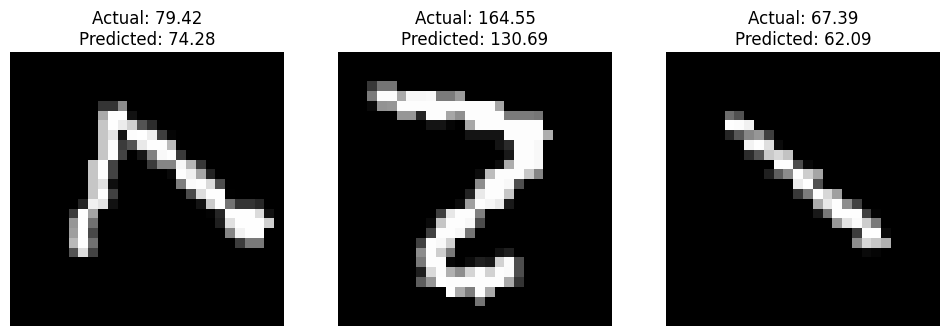

In [ ]:
show_loader = get_test_angle_dataset("MNIST", batch_size=3)

rotation_model.eval()
loaded_model.eval()
loaded_model.to(device)
rotation_model.to(device)

for images, actual_angles in show_loader:
    images = images.to(device)
    with torch.no_grad():
        features = loaded_model.base_model(images).to(device)
        predicted_angles = rotation_model(features).cpu().numpy().flatten()

    # Display the first batch of 3 examples
    display_examples(images, actual_angles.numpy(), predicted_angles, 3)
    break

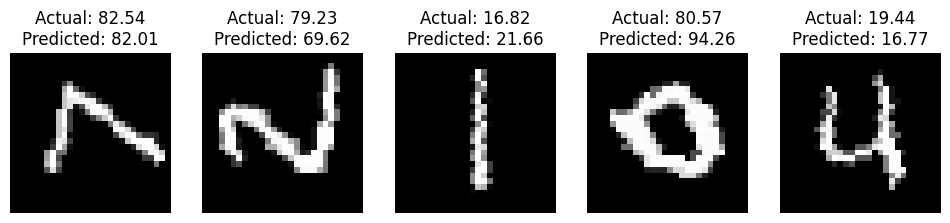

In [ ]:
show_loader = get_test_angle_dataset("MNIST", batch_size=5)

rotation_model.eval()
loaded_model.eval()
loaded_model.to(device)
rotation_model.to(device)

for images, actual_angles in show_loader:
    images = images.to(device)
    with torch.no_grad():
        features = loaded_model.base_model(images).to(device)
        predicted_angles = rotation_model(features).cpu().numpy().flatten()

    # Display the first batch of 5 examples
    display_examples(images, actual_angles.numpy(), predicted_angles, 5)
    break

In [ ]:
def test_rotation_regression(model, feature_extractor, data_loader, criterion, device):
    model.eval()
    feature_extractor.eval()
    total_loss = 0.0

    with torch.no_grad():
        for x, angle in tqdm(data_loader, desc="Testing"):
            x = x.to(device)
            angle = angle.to(device).float().unsqueeze(1)

            # features = feature_extractor(x)
            # # features = features.view(features.size(0), -1)  # Flatten features
            features=x
            outputs = model(features)
            loss = criterion(outputs, angle)
            total_loss += loss.item()

    avg_loss = total_loss / len(data_loader)
    print(f'Test Loss: {avg_loss}')
    return avg_loss


In [ ]:
test_loss = test_rotation_regression(rotation_model, feature_extractor, test_loader, criterion, device)

Testing: 100%|██████████| 157/157 [00:00<00:00, 710.82it/s]

Test Loss: 670.1101274429612


In [ ]:
test_loss

670.1101274429612

## Apply intrinsic

### Preparations

In [ ]:
pip install giotto-ph gudhi pot

In [ ]:
os.chdir('/')
if not os.path.exists("/intrinsic"):
    !git clone https://github.com/katyafilimoshina/intrinsic.git


In [ ]:
!git pull origin main

In [ ]:
from intrinsic.functional.magnitude import magnitude
from intrinsic.functional.dimension import two_nn, mle
from intrinsic.functional.curvature import curvature
from intrinsic.functional.homology import vr_diagrams, drop_inf, betti, euler, diagrams_barycenter, persistence_entropy, persistence_norm, total_persistence, amplitude, landscapes, wasserstein_distance, cross_barcode, r_cross_barcode, mtd, rtd, frechet_mean

In [ ]:
def plot_feature(model, data, feature, results, num_epochs, layers, list_relative_depths):
    plt.figure(figsize=(12, 8))
    for epoch in range(num_epochs):
      plt.plot(list_relative_depths[0:len(layers)+1], results[epoch * len(layers):epoch * len(layers)+len(layers)], label=f'Epoch {epoch*5 + 1}', marker='o')
    plt.xlabel('Relative depth')
    plt.ylabel(f'{feature}')
    plt.title(f'{model} | {data} | {feature} over layers on different epochs')
    plt.legend(title='Epochs')
    plt.show()

### For all test

#### ID

In [ ]:
def id_experiment(list_embs, k=10):
  ids_mle, ids_two_nn = [], []
  for num_emb in range(len(list_embs)):
    ids_two_nn.append(two_nn(list_embs[num_emb]))
    ids_mle.append(mle(list_embs[num_emb], k).mean())
  return ids_two_nn, ids_mle

In [ ]:
reduced_embs = []

for embeddings in list_embs:
    reduced_embs.append(embeddings[:15000])

for i, reduced_embeddings in enumerate(reduced_embs):
    print(f"Epoch {i+1}, Reduced Embedding shape: {reduced_embeddings.shape}")

Epoch 1, Reduced Embedding shape: (15000, 3136)
Epoch 2, Reduced Embedding shape: (15000, 2048)
Epoch 3, Reduced Embedding shape: (15000, 1024)
Epoch 4, Reduced Embedding shape: (15000, 512)
Epoch 5, Reduced Embedding shape: (15000, 3136)
Epoch 6, Reduced Embedding shape: (15000, 2048)
Epoch 7, Reduced Embedding shape: (15000, 1024)
Epoch 8, Reduced Embedding shape: (15000, 512)
Epoch 9, Reduced Embedding shape: (15000, 3136)
Epoch 10, Reduced Embedding shape: (15000, 2048)
Epoch 11, Reduced Embedding shape: (15000, 1024)
Epoch 12, Reduced Embedding shape: (15000, 512)
Epoch 13, Reduced Embedding shape: (15000, 3136)
Epoch 14, Reduced Embedding shape: (15000, 2048)
Epoch 15, Reduced Embedding shape: (15000, 1024)
Epoch 16, Reduced Embedding shape: (15000, 512)
Epoch 17, Reduced Embedding shape: (15000, 3136)
Epoch 18, Reduced Embedding shape: (15000, 2048)
Epoch 19, Reduced Embedding shape: (15000, 1024)
Epoch 20, Reduced Embedding shape: (15000, 512)


In [ ]:
ids_two_nn_simclr, ids_mle_simclr = id_experiment(reduced_embs)

In [ ]:
ids_two_nn_simclr, ids_mle_simclr

([20.923566376642672,
  20.543390704705182,
  17.822066981889375,
  11.867997806987,
  16.379627592494142,
  16.515556721079744,
  16.475620687623948,
  13.863656310939945,
  16.01684245180193,
  15.737366255525837,
  15.907244615543199,
  14.414791350842213,
  16.894154203567666,
  15.928227850250073,
  15.782486593653648,
  14.523450762172729,
  16.398672903397955,
  15.999956943312926,
  15.89511609741626,
  14.383493309865644],
 [25.29912944849541,
  25.421609909337114,
  20.875144891070175,
  26.90450328402575,
  18.33649722074137,
  17.620405774405242,
  16.836922119127944,
  12.919335692888906,
  18.341008117556967,
  17.099363377964558,
  16.449725937985917,
  13.438179517423935,
  18.605829959852265,
  16.92930876443817,
  16.367485605985085,
  13.462245131038626,
  18.65292665022671,
  17.069333427874266,
  16.32241775209388,
  13.592021494669828])

In [ ]:
ids_two_nn_normalized, ids_mle_normalized = [], []
for i in range(len(ids_two_nn_simclr)):
  ids_two_nn_normalized.append(ids_two_nn_simclr[i] / reduced_embs[i].shape[1])
  ids_mle_normalized.append(ids_mle_simclr[i] / reduced_embs[i].shape[1])

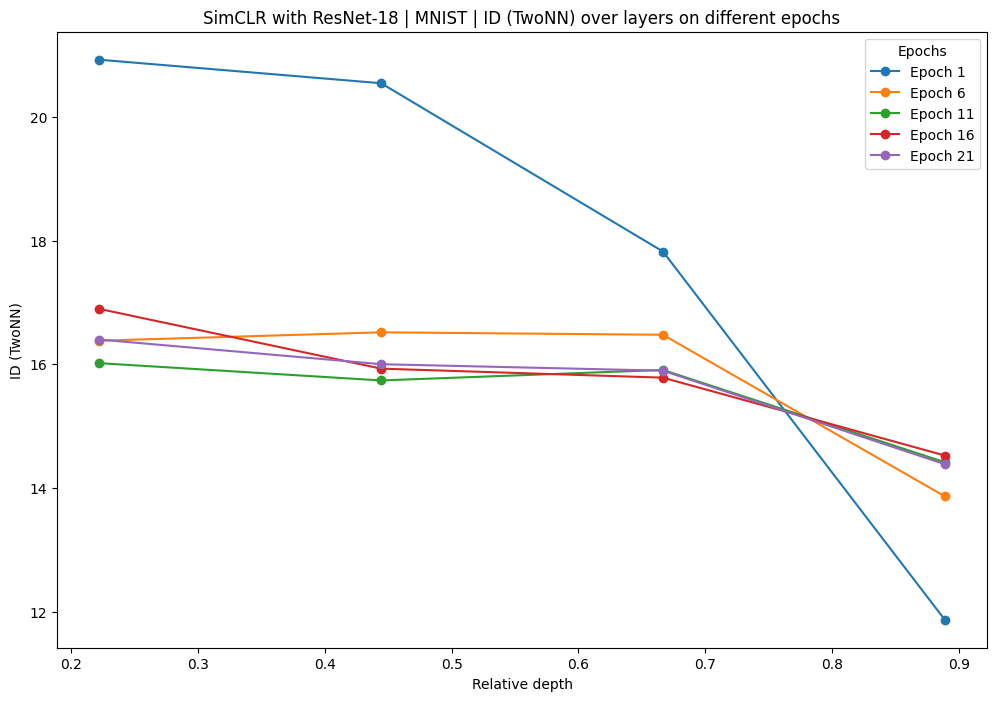

In [ ]:
plot_feature(model="SimCLR with ResNet-18", data="MNIST", feature="ID (TwoNN)", results=ids_two_nn_simclr, num_epochs=5, layers=layers_simclr, list_relative_depths=normalized_depths)

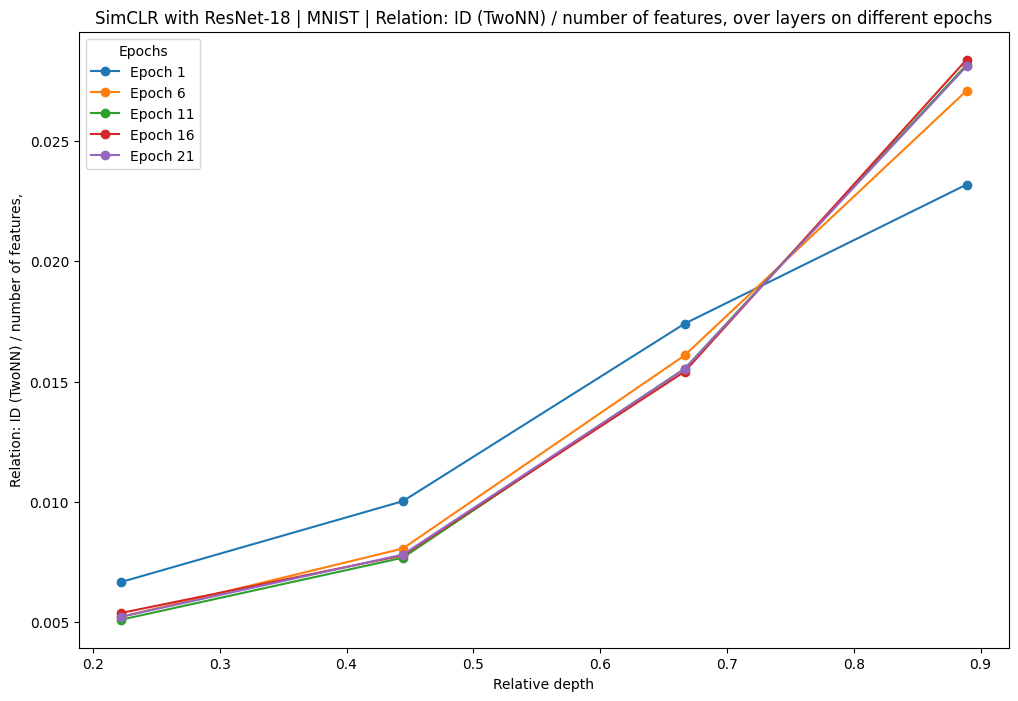

In [ ]:
plot_feature(model="SimCLR with ResNet-18", data="MNIST", feature="Relation: ID (TwoNN) / number of features,", results=ids_two_nn_normalized, num_epochs=5, layers=layers_simclr, list_relative_depths=normalized_depths)

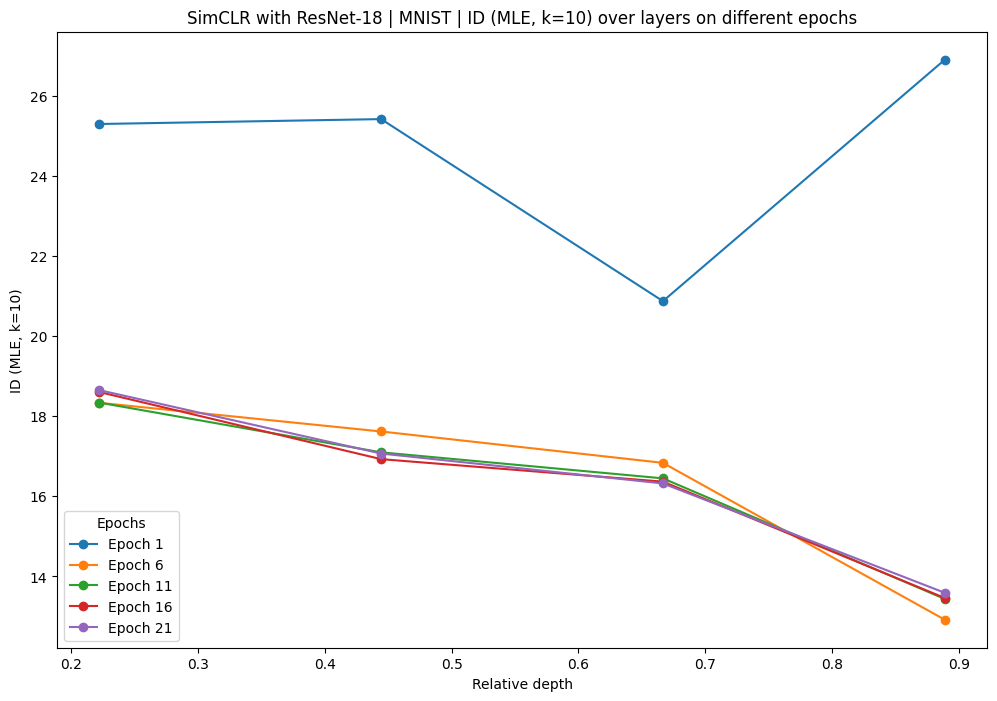

In [ ]:
plot_feature(model="SimCLR with ResNet-18", data="MNIST", feature="ID (MLE, k=10)", results=ids_mle_simclr, num_epochs=5, layers=layers_simclr, list_relative_depths=normalized_depths)

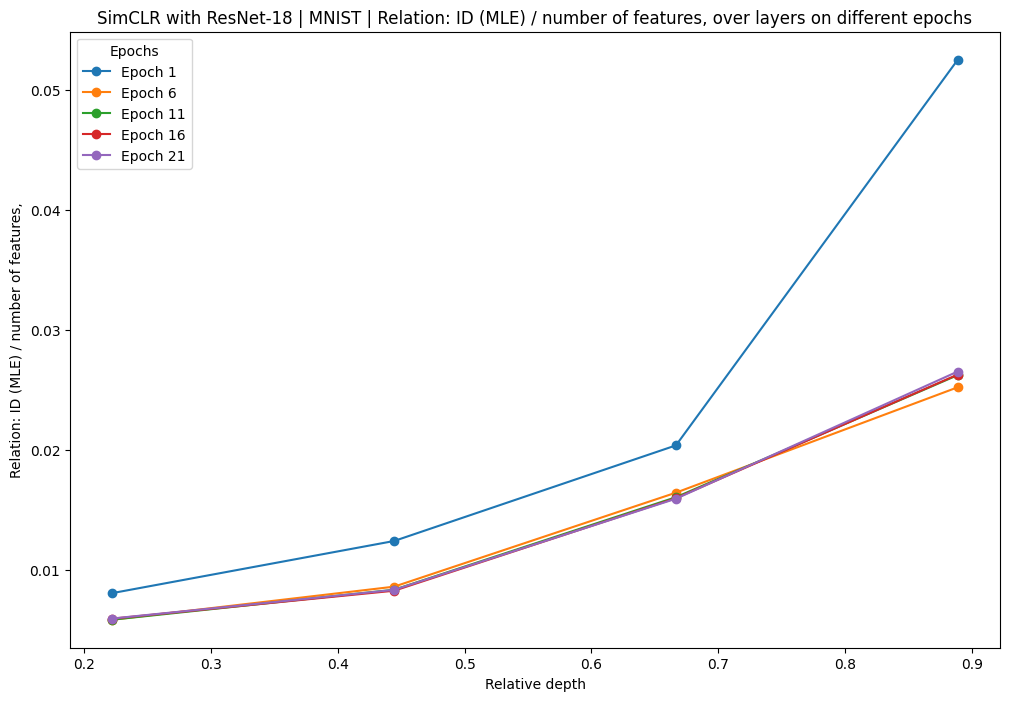

In [ ]:
plot_feature(model="SimCLR with ResNet-18", data="MNIST", feature="Relation: ID (MLE) / number of features,", results=ids_mle_normalized, num_epochs=5, layers=layers_simclr, list_relative_depths=normalized_depths)

In [ ]:
loaded_model

SimCLR(
  (base_model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_r

#### Magnitude

In [ ]:
def magnitude_experiment(list_embs):
  magnitudes = []
  for num_emb in range(len(list_embs)):
    magnitudes.append(magnitude(list_embs[num_emb]))
  return magnitudes

In [ ]:
reduced_embs = []

for embeddings in list_embs:
    reduced_embs.append(embeddings[:1000])

for i, reduced_embeddings in enumerate(reduced_embs):
    print(f"Epoch {i+1}, Reduced Embedding shape: {reduced_embeddings.shape}")

Epoch 1, Reduced Embedding shape: (1000, 3136)
Epoch 2, Reduced Embedding shape: (1000, 2048)
Epoch 3, Reduced Embedding shape: (1000, 1024)
Epoch 4, Reduced Embedding shape: (1000, 512)
Epoch 5, Reduced Embedding shape: (1000, 3136)
Epoch 6, Reduced Embedding shape: (1000, 2048)
Epoch 7, Reduced Embedding shape: (1000, 1024)
Epoch 8, Reduced Embedding shape: (1000, 512)
Epoch 9, Reduced Embedding shape: (1000, 3136)
Epoch 10, Reduced Embedding shape: (1000, 2048)
Epoch 11, Reduced Embedding shape: (1000, 1024)
Epoch 12, Reduced Embedding shape: (1000, 512)
Epoch 13, Reduced Embedding shape: (1000, 3136)
Epoch 14, Reduced Embedding shape: (1000, 2048)
Epoch 15, Reduced Embedding shape: (1000, 1024)
Epoch 16, Reduced Embedding shape: (1000, 512)
Epoch 17, Reduced Embedding shape: (1000, 3136)
Epoch 18, Reduced Embedding shape: (1000, 2048)
Epoch 19, Reduced Embedding shape: (1000, 1024)
Epoch 20, Reduced Embedding shape: (1000, 512)


In [ ]:
magnitudes = magnitude_experiment(reduced_embs)

In [ ]:
magnitudes

[999.9999999964832,
 999.9999957364497,
 999.998575775214,
 999.9990129836177,
 999.9999999993366,
 999.999996820781,
 999.9949699687978,
 968.5180037751968,
 999.9999999999961,
 999.9999993774746,
 999.9953325218313,
 978.7406590738404,
 999.9999999999657,
 999.9999996044158,
 999.9969362485373,
 986.4655441577511,
 999.999999999832,
 999.9999971374586,
 999.9982520001004,
 988.0084743937074]

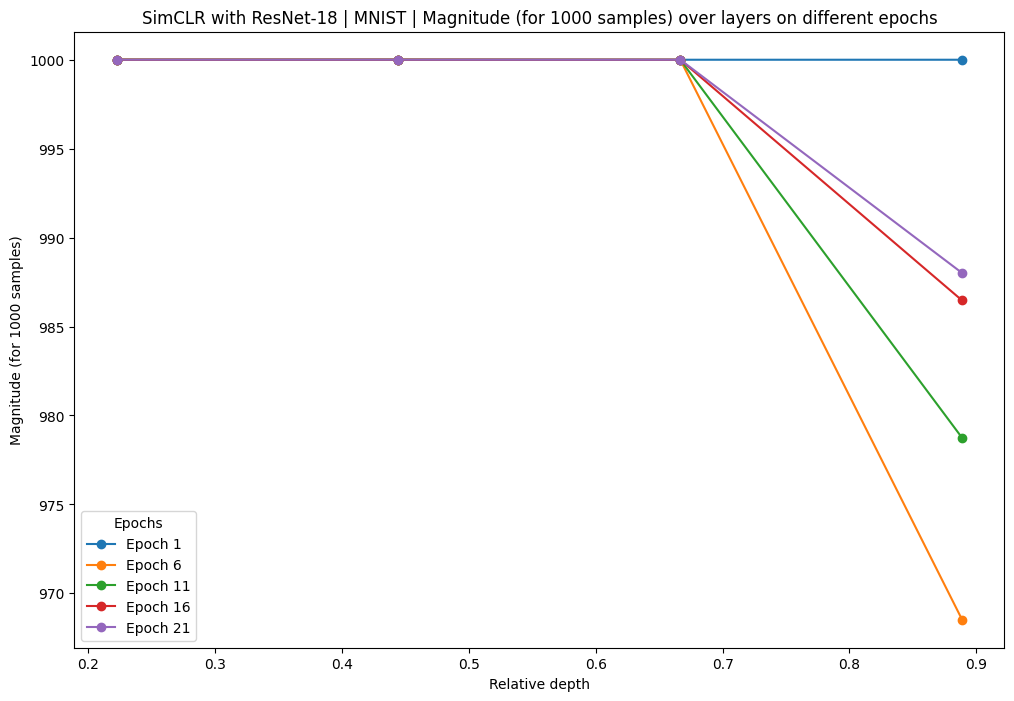

In [ ]:
plot_feature(model="SimCLR with ResNet-18", data="MNIST", feature='Magnitude (for 1000 samples)', results=magnitudes, num_epochs=5, layers=layers_simclr[-5:], list_relative_depths=normalized_depths)

#### Curvature

In [ ]:
def curvature_experiment(list_embs, k=3):
  curvatures = []
  for num_emb in range(len(list_embs)):
    curvatures.append(np.ma.masked_invalid(curvature(list_embs[num_emb], k)).mean())
  return curvatures

In [ ]:
curvatures = curvature_experiment(normalized_embs)

In [ ]:
curvatures

[masked,
 masked,
 -1.0531557942878041e+266,
 -2.4300831341051155e+136,
 -1.6528986037808117e+112,
 -4590095621042272.0,
 masked,
 masked,
 masked,
 -5.183359736490712e+144,
 -1.1174545038228793e+131,
 -2.7905527212133374e+20,
 masked,
 masked,
 masked,
 -1.6832723644120752e+132,
 -1.5498368016036123e+123,
 -2.633130540504003e+16,
 masked,
 masked,
 masked,
 -1.8695131022634515e+161,
 -1.2252329255446969e+154,
 -3.8013312670756683e+23,
 masked,
 masked,
 masked,
 -1.4256895753541072e+103,
 -7.777895235409942e+113,
 -9.339527235092607e+20]

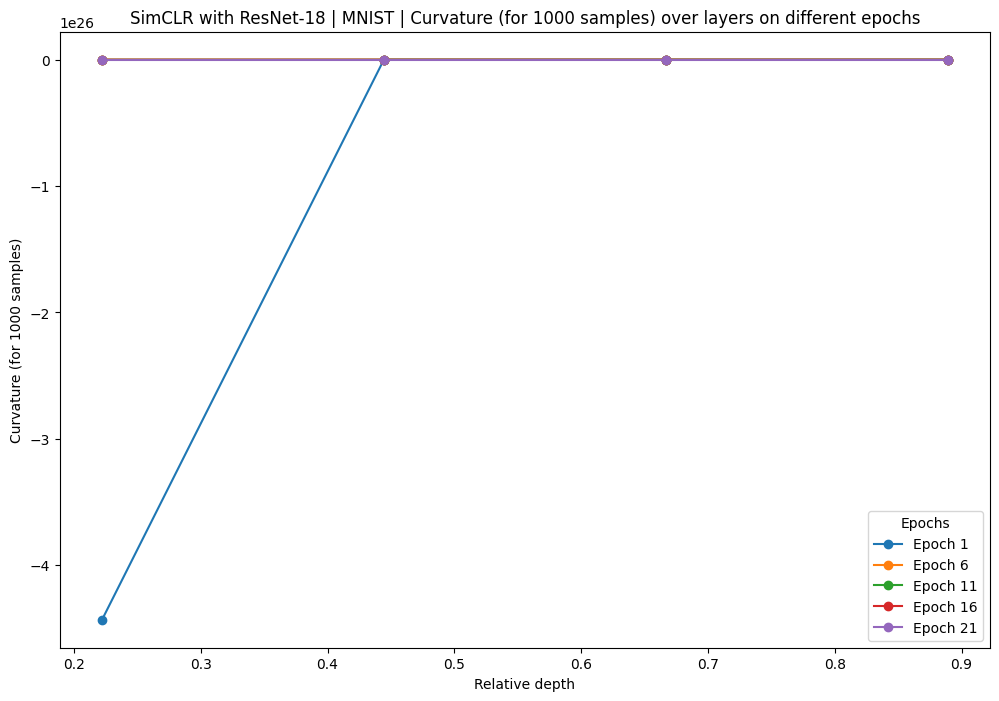

In [ ]:
plot_feature(model="SimCLR with ResNet-18", data="MNIST", feature='Curvature (for 1000 samples)', results=curvatures, num_epochs=5, layers=layers_simclr[-5:], list_relative_depths=normalized_depths)

#### Persistence diagrams

In [ ]:
pip install persim

In [ ]:
import persim
from sklearn.preprocessing import normalize

In [ ]:
reduced_embs = []

for embeddings in list_embs:
    reduced_embs.append(embeddings[:1000])

for i, reduced_embeddings in enumerate(reduced_embs):
    print(f"Epoch {i+1}, Reduced Embedding shape: {reduced_embeddings.shape}")

Epoch 1, Reduced Embedding shape: (1000, 3136)
Epoch 2, Reduced Embedding shape: (1000, 2048)
Epoch 3, Reduced Embedding shape: (1000, 1024)
Epoch 4, Reduced Embedding shape: (1000, 512)
Epoch 5, Reduced Embedding shape: (1000, 3136)
Epoch 6, Reduced Embedding shape: (1000, 2048)
Epoch 7, Reduced Embedding shape: (1000, 1024)
Epoch 8, Reduced Embedding shape: (1000, 512)
Epoch 9, Reduced Embedding shape: (1000, 3136)
Epoch 10, Reduced Embedding shape: (1000, 2048)
Epoch 11, Reduced Embedding shape: (1000, 1024)
Epoch 12, Reduced Embedding shape: (1000, 512)
Epoch 13, Reduced Embedding shape: (1000, 3136)
Epoch 14, Reduced Embedding shape: (1000, 2048)
Epoch 15, Reduced Embedding shape: (1000, 1024)
Epoch 16, Reduced Embedding shape: (1000, 512)
Epoch 17, Reduced Embedding shape: (1000, 3136)
Epoch 18, Reduced Embedding shape: (1000, 2048)
Epoch 19, Reduced Embedding shape: (1000, 1024)
Epoch 20, Reduced Embedding shape: (1000, 512)


In [ ]:
normalized_embs = []
for emb in reduced_embs:
  normalized_embs.append(normalize(emb, axis=0, norm='max'))

In [ ]:
def get_vr_diagrams(normalized_embs):
  vrs = []
  for i in range(len(normalized_embs)):
    vrs.append(drop_inf(vr_diagrams(normalized_embs[i])))
  return vrs

In [ ]:
vrs = get_vr_diagrams(normalized_embs)
vrs

[[array([[ 0.       ,  3.5725684],
         [ 0.       ,  3.6767871],
         [ 0.       ,  3.7261617],
         ...,
         [ 0.       , 14.820585 ],
         [ 0.       , 14.865767 ],
         [ 0.       , 15.500716 ]], dtype=float32),
  array([[14.930616 , 14.954631 ],
         [14.929781 , 15.275088 ],
         [14.591104 , 14.637769 ],
         ...,
         [ 4.5617123,  4.565309 ],
         [ 4.4363117,  4.5386405],
         [ 4.429324 ,  4.496903 ]], dtype=float32)],
 [array([[ 0.       ,  3.4702795],
         [ 0.       ,  3.4747386],
         [ 0.       ,  3.6002114],
         ...,
         [ 0.       , 11.801917 ],
         [ 0.       , 12.152325 ],
         [ 0.       , 12.390132 ]], dtype=float32),
  array([[11.916707 , 12.033744 ],
         [11.831843 , 11.892747 ],
         [11.455329 , 11.491764 ],
         ...,
         [ 4.310597 ,  4.4515886],
         [ 4.172107 ,  4.2168055],
         [ 4.137793 ,  4.316652 ]], dtype=float32)],
 [array([[0.       , 2.144802 ],
 

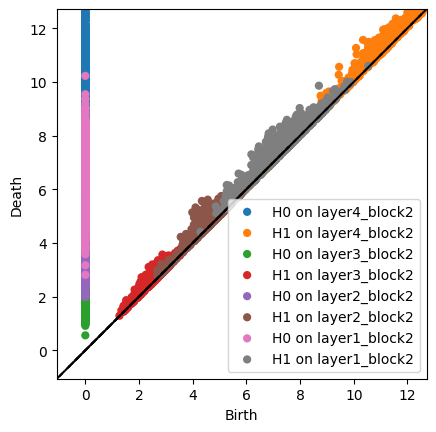

In [ ]:
for i in range(4):
  persim.plot_diagrams(vrs[-i], labels=[f'H0 on {layers_simclr[-i-1]}', f'H1 on {layers_simclr[-i-1]}'], size=35)

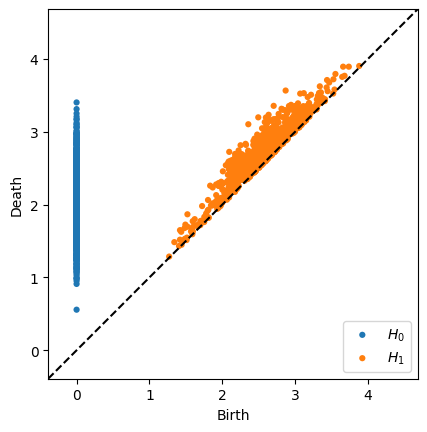

In [ ]:
persim.plot_diagrams(vrs[-1])

In [ ]:
layers_simclr.sort()

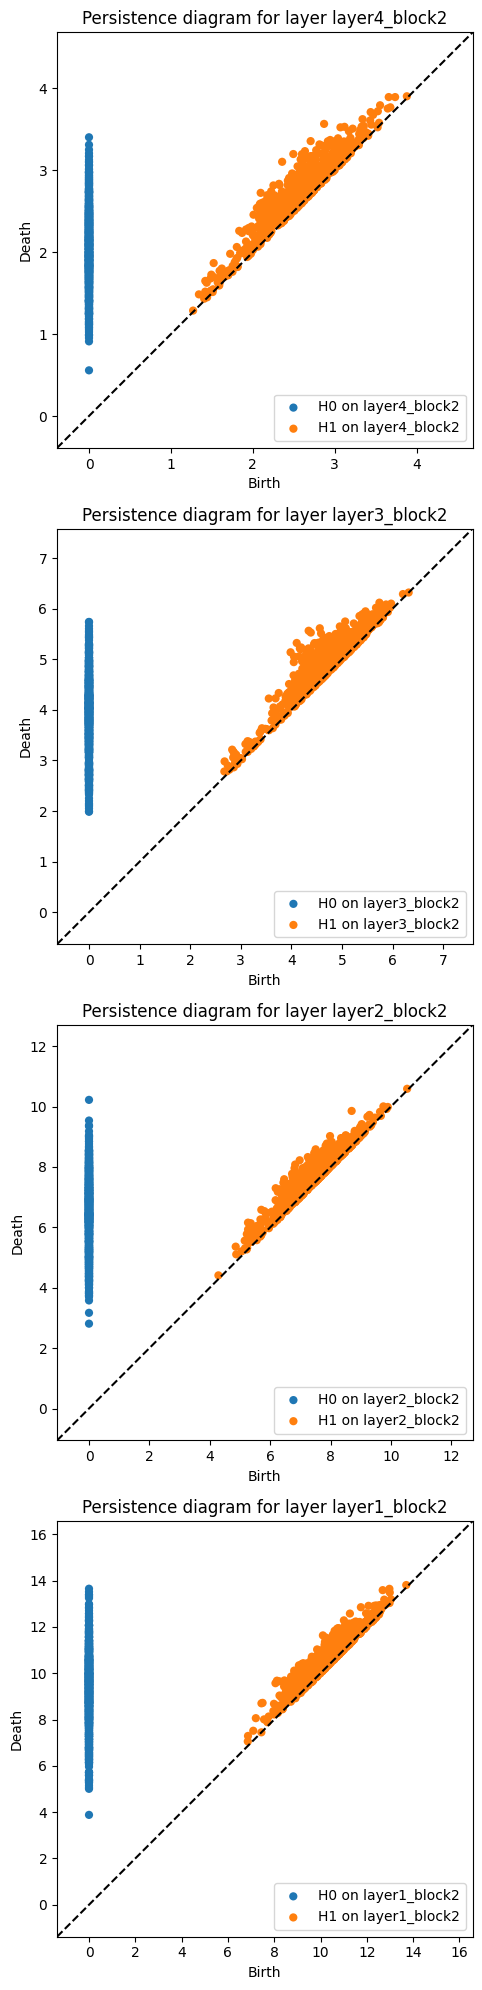

In [ ]:
num_diagrams = 4 # Number of diagrams to plot
fig, axes = plt.subplots(num_diagrams, 1, figsize=(10, num_diagrams * 5))

for i in range(num_diagrams):
    ax = axes[i]
    persim.plot_diagrams(vrs[-(i+1)], labels=[f'H0 on {layers_simclr[-(i+1)]}', f'H1 on {layers_simclr[-(i+1)]}'], size=35, ax=ax)
    ax.set_title(f'Persistence diagram for layer {layers_simclr[-(i+1)]}')

plt.tight_layout()
plt.show()

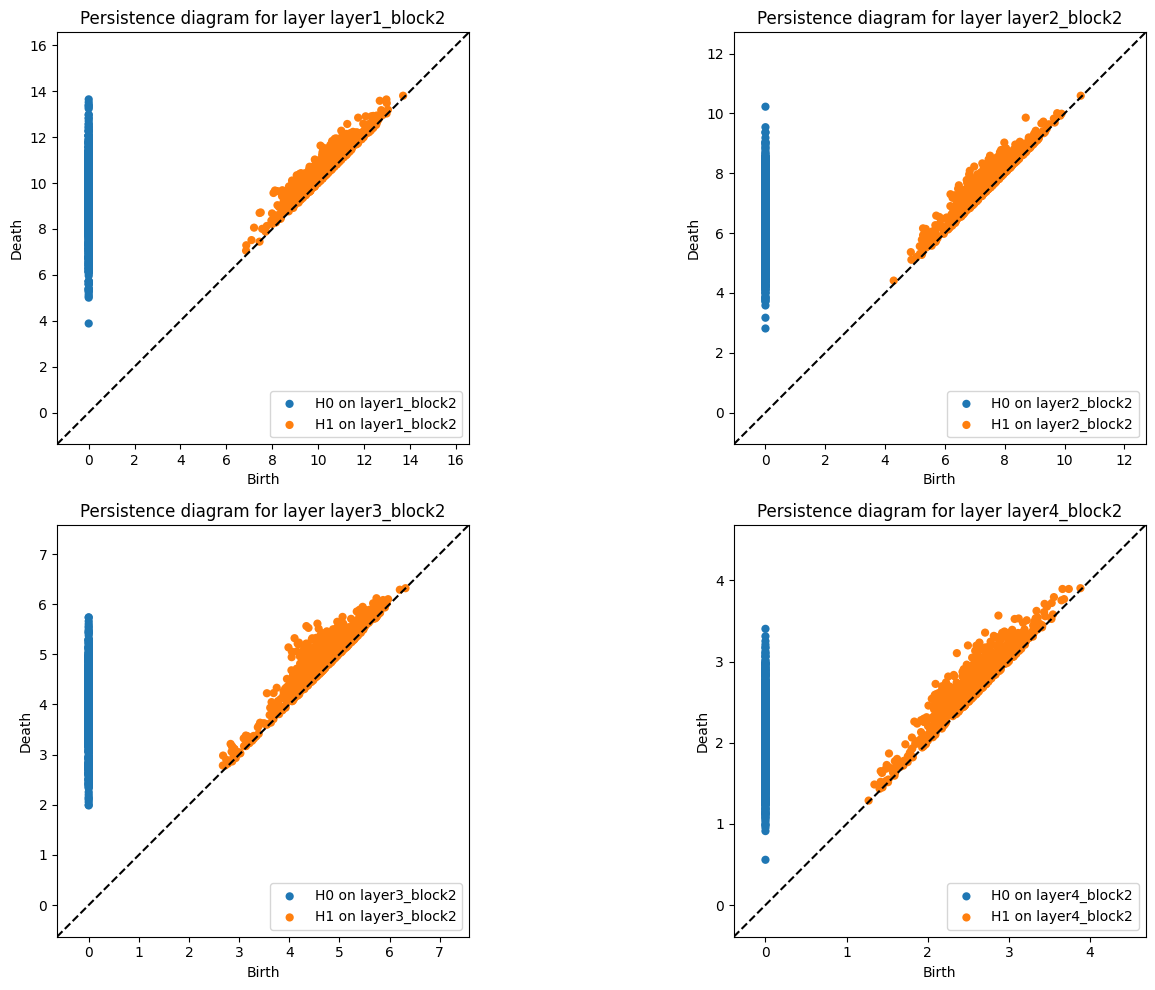

In [ ]:
num_diagrams = 4  # Number of diagrams to plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2 rows, 3 columns

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each persistence diagram in a subplot
for i in range(num_diagrams):
    ax = axes[i]
    persim.plot_diagrams(vrs[-(num_diagrams-i)], labels=[f'H0 on {layers_simclr[-(num_diagrams-i)]}', f'H1 on {layers_simclr[-(num_diagrams-i)]}'], size=35, ax=ax)
    ax.set_title(f'Persistence diagram for layer {layers_simclr[-(num_diagrams-i)]}')

# Hide any empty subplots (if fewer than 6 diagrams)
for j in range(num_diagrams, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


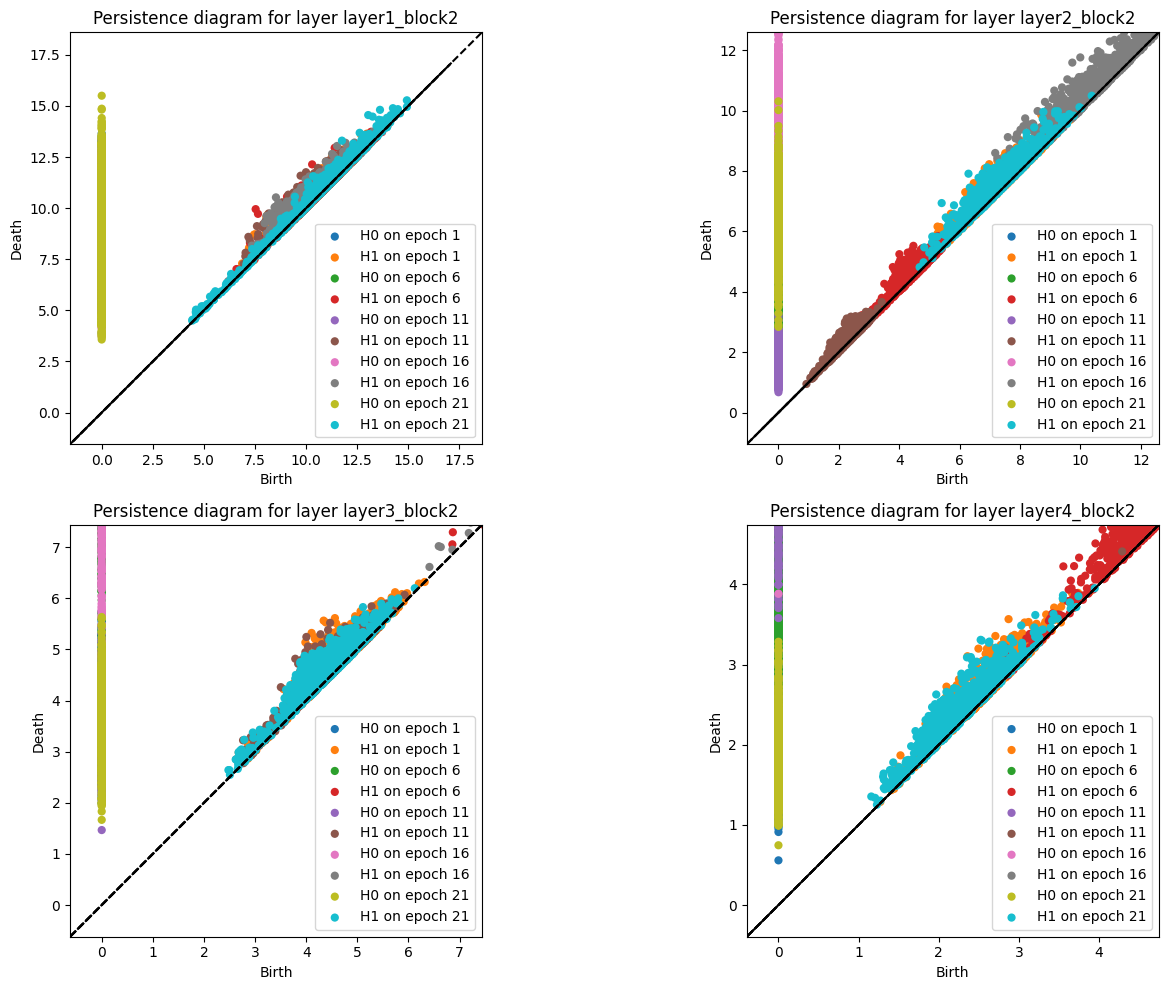

In [ ]:
num_diagrams = 4  # Number of diagrams to plot
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # 2 rows, 3 columns

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each persistence diagram in a subplot
for i in range(num_diagrams):
    ax = axes[i]
    for epoch in range(1,6):
      persim.plot_diagrams(vrs[-epoch*(num_diagrams-i)], labels=[f'H0 on epoch {epoch*5-4}', f'H1 on epoch {epoch*5-4}'], size=35, ax=ax)
      ax.set_title(f'Persistence diagram for layer {layers_simclr[-(num_diagrams-i)]}')

# Hide any empty subplots (if fewer than 6 diagrams)
for j in range(num_diagrams, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### Total persistence

In [ ]:
def total_persistence_experiment(vrs, q):
  total_persistences = []
  for num_emb in range(len(vrs)):
    total_persistences.append(total_persistence(vrs[num_emb], q))
    print(f'Epoch: {list_epochs[num_emb]} | Layer: {list_layers[num_emb]} | Total persistence: {total_persistences[num_emb]}')
  return total_persistences

In [ ]:
total_p_half = total_persistence_experiment(vrs, q=0.5)

Epoch: 1 | Layer: layer1_block2 | Total persistence: 3228.05810546875
Epoch: 1 | Layer: layer2_block2 | Total persistence: 2887.457763671875
Epoch: 1 | Layer: layer3_block2 | Total persistence: 2377.64697265625
Epoch: 1 | Layer: layer4_block2 | Total persistence: 2185.906982421875
Epoch: 6 | Layer: layer1_block2 | Total persistence: 3567.361328125
Epoch: 6 | Layer: layer2_block2 | Total persistence: 3097.58056640625
Epoch: 6 | Layer: layer3_block2 | Total persistence: 2272.38818359375
Epoch: 6 | Layer: layer4_block2 | Total persistence: 1538.68994140625
Epoch: 11 | Layer: layer1_block2 | Total persistence: 3627.9111328125
Epoch: 11 | Layer: layer2_block2 | Total persistence: 3115.290771484375
Epoch: 11 | Layer: layer3_block2 | Total persistence: 2363.55810546875
Epoch: 11 | Layer: layer4_block2 | Total persistence: 1620.4306640625
Epoch: 16 | Layer: layer1_block2 | Total persistence: 3638.642578125
Epoch: 16 | Layer: layer2_block2 | Total persistence: 3111.9453125
Epoch: 16 | Layer: la

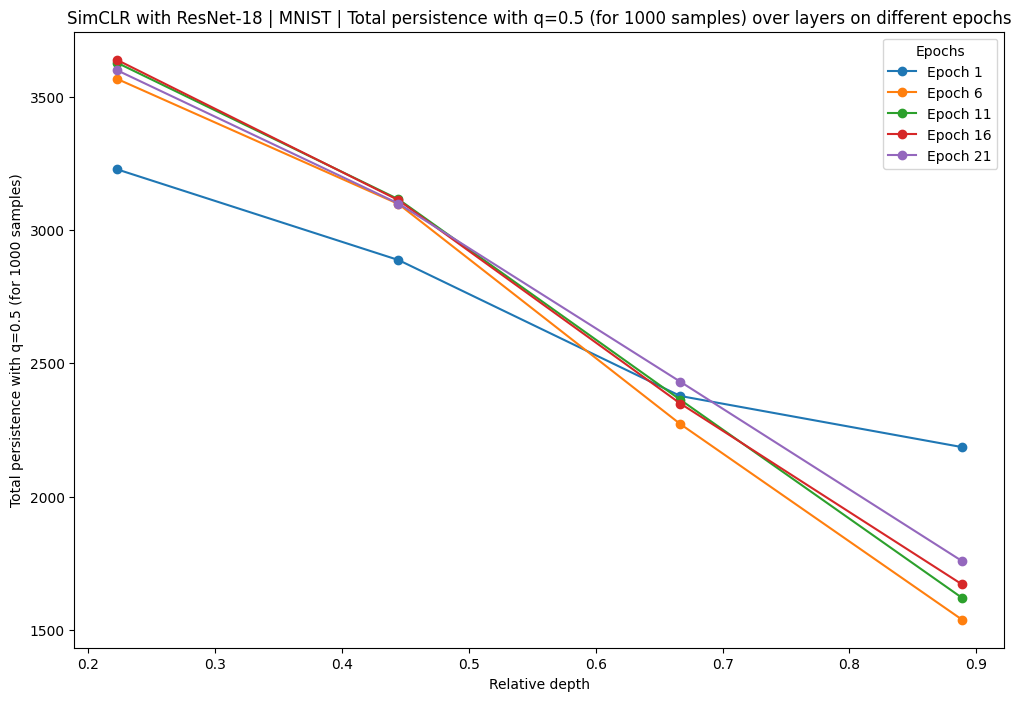

In [ ]:
plot_feature(model="SimCLR with ResNet-18", data="MNIST", feature='Total persistence with q=0.5 (for 1000 samples)', results=total_p_half, num_epochs=5, layers=layers_simclr[-4:], list_relative_depths=normalized_depths)

In [ ]:
total_p_full = total_persistence_experiment(vrs, q=1)

Epoch: 1 | Layer: layer1_block2 | Total persistence: 9124.54296875
Epoch: 1 | Layer: layer2_block2 | Total persistence: 7483.59375
Epoch: 1 | Layer: layer3_block2 | Total persistence: 5007.9990234375
Epoch: 1 | Layer: layer4_block2 | Total persistence: 4210.818359375
Epoch: 6 | Layer: layer1_block2 | Total persistence: 9571.23828125
Epoch: 6 | Layer: layer2_block2 | Total persistence: 6737.4541015625
Epoch: 6 | Layer: layer3_block2 | Total persistence: 3699.119873046875
Epoch: 6 | Layer: layer4_block2 | Total persistence: 1729.8994140625
Epoch: 11 | Layer: layer1_block2 | Total persistence: 9705.37109375
Epoch: 11 | Layer: layer2_block2 | Total persistence: 6876.99853515625
Epoch: 11 | Layer: layer3_block2 | Total persistence: 3933.237060546875
Epoch: 11 | Layer: layer4_block2 | Total persistence: 1877.7449951171875
Epoch: 16 | Layer: layer1_block2 | Total persistence: 9794.5537109375
Epoch: 16 | Layer: layer2_block2 | Total persistence: 6871.375
Epoch: 16 | Layer: layer3_block2 | Tota

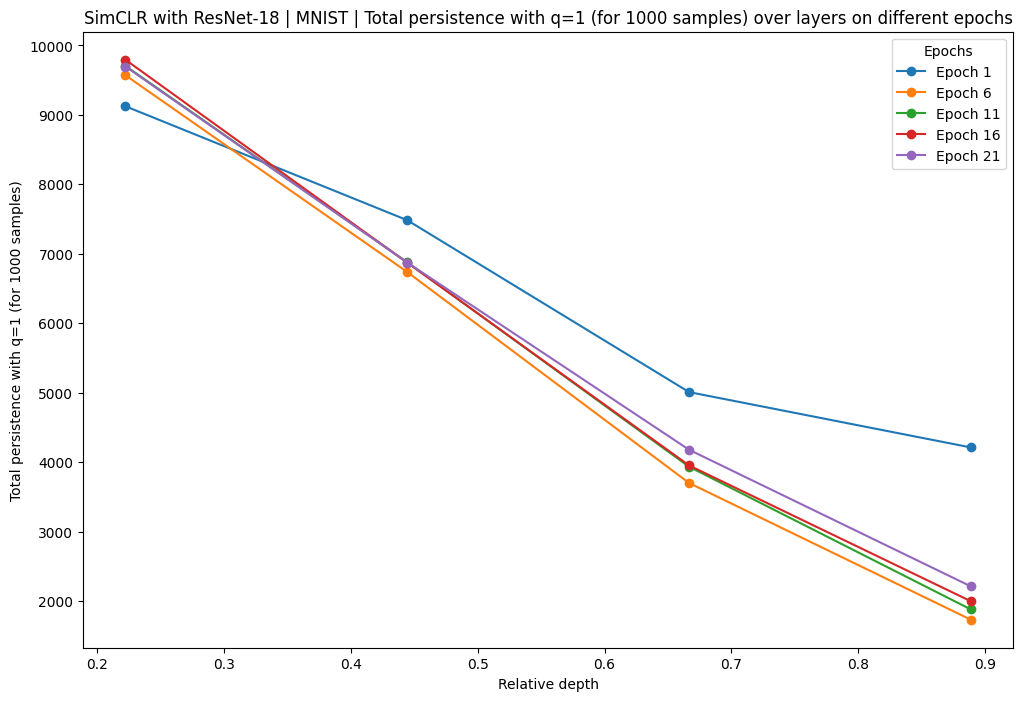

In [ ]:
plot_feature(model="SimCLR with ResNet-18", data="MNIST", feature='Total persistence with q=1 (for 1000 samples)', results=total_p_full, num_epochs=5, layers=layers_simclr[-4:], list_relative_depths=normalized_depths)

#### Persistence entropy

In [ ]:
from intrinsic.functional.homology import persistence_entropy

In [ ]:
vrs[0][1]

array([[14.930616 , 14.954631 ],
       [14.929781 , 15.275088 ],
       [14.591104 , 14.637769 ],
       ...,
       [ 4.5617123,  4.565309 ],
       [ 4.4363117,  4.5386405],
       [ 4.429324 ,  4.496903 ]], dtype=float32)

In [ ]:
def persistence_entropy_experiment(vrs):
  persistence_entropies = []
  for num_emb in range(len(vrs)):
    persistence_entropies.append(persistence_entropy(vrs[num_emb]))
    print(f'Epoch: {list_epochs[num_emb]} | Layer: {list_layers[num_emb]} | Persistent entropies (for H0, H1): {persistence_entropies[num_emb]}')
  return persistence_entropies

In [ ]:
persistent_entropies = persistence_entropy_experiment(vrs)

Epoch: 1 | Layer: layer1_block2 | Persistent entropies (for H0, H1): [6.86821   6.0072303]
Epoch: 1 | Layer: layer2_block2 | Persistent entropies (for H0, H1): [6.8786716 5.921482 ]
Epoch: 1 | Layer: layer3_block2 | Persistent entropies (for H0, H1): [6.8764257 6.0467906]
Epoch: 1 | Layer: layer4_block2 | Persistent entropies (for H0, H1): [6.8903103 6.037171 ]
Epoch: 6 | Layer: layer1_block2 | Persistent entropies (for H0, H1): [6.8922386 6.5615396]
Epoch: 6 | Layer: layer2_block2 | Persistent entropies (for H0, H1): [6.8920164 6.737172 ]
Epoch: 6 | Layer: layer3_block2 | Persistent entropies (for H0, H1): [6.892337 6.561877]
Epoch: 6 | Layer: layer4_block2 | Persistent entropies (for H0, H1): [6.8820496 6.3104   ]
Epoch: 11 | Layer: layer1_block2 | Persistent entropies (for H0, H1): [6.8929873 6.639137 ]
Epoch: 11 | Layer: layer2_block2 | Persistent entropies (for H0, H1): [6.8924084 6.737126 ]
Epoch: 11 | Layer: layer3_block2 | Persistent entropies (for H0, H1): [6.8921723 6.626773 

In [ ]:
persistent_entropies

[array([6.86821  , 6.0072303], dtype=float32),
 array([6.8786716, 5.921482 ], dtype=float32),
 array([6.8764257, 6.0467906], dtype=float32),
 array([6.8903103, 6.037171 ], dtype=float32),
 array([6.8922386, 6.5615396], dtype=float32),
 array([6.8920164, 6.737172 ], dtype=float32),
 array([6.892337, 6.561877], dtype=float32),
 array([6.8820496, 6.3104   ], dtype=float32),
 array([6.8929873, 6.639137 ], dtype=float32),
 array([6.8924084, 6.737126 ], dtype=float32),
 array([6.8921723, 6.626773 ], dtype=float32),
 array([6.88203  , 6.3828545], dtype=float32),
 array([6.89357 , 6.655575], dtype=float32),
 array([6.893299 , 6.7394886], dtype=float32),
 array([6.894425 , 6.5584593], dtype=float32),
 array([6.883893, 6.417976], dtype=float32),
 array([6.89423 , 6.605413], dtype=float32),
 array([6.8926125, 6.7241936], dtype=float32),
 array([6.891968, 6.606424], dtype=float32),
 array([6.885314, 6.466587], dtype=float32)]

#### RTD Score between the embeddings

In [ ]:
from intrinsic.functional.homology import wasserstein_distance, rtd

In [ ]:
rtd(normalized_embs[-1], normalized_embs[-2])

array([  0.        , 109.64613891])

In [ ]:
rtd(normalized_embs[-1], normalized_embs[-5])

array([  0.        , 762.11422622])

In [ ]:
rtd(normalized_embs[-2], normalized_embs[-6])

array([   0.        , 1101.37126017])

In [ ]:
rtd(normalized_embs[-1], normalized_embs[-9])

array([  0.        , 827.74979717])

In [ ]:
rtd(normalized_embs[-1], normalized_embs[-13])

array([  0.        , 878.16023594])

### By rotation angle bins

In [ ]:
def categorize_angles(angles):
    categories = np.digitize(angles, bins=np.arange(20, 181, 20))
    return categories

In [ ]:
categories = categorize_angles(test_labels)

category_dict = {i: [] for i in range(9)}

for i, category in enumerate(categories):
    category_dict[category].append(test_embeddings[i])

for category in category_dict:
    category_dict[category] = np.array(category_dict[category])

for category, embeddings in category_dict.items():
    print(f"Category {category}: {embeddings.shape[0]} samples")

Category 0: 1114 samples
Category 1: 1122 samples
Category 2: 1161 samples
Category 3: 1126 samples
Category 4: 1145 samples
Category 5: 1070 samples
Category 6: 1141 samples
Category 7: 1120 samples
Category 8: 1001 samples


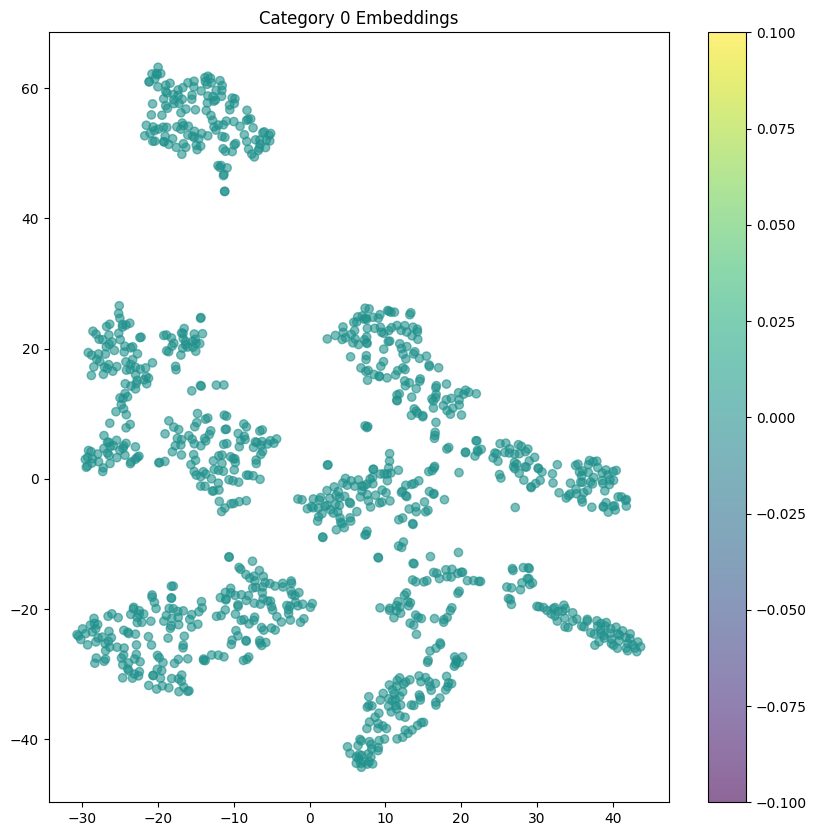

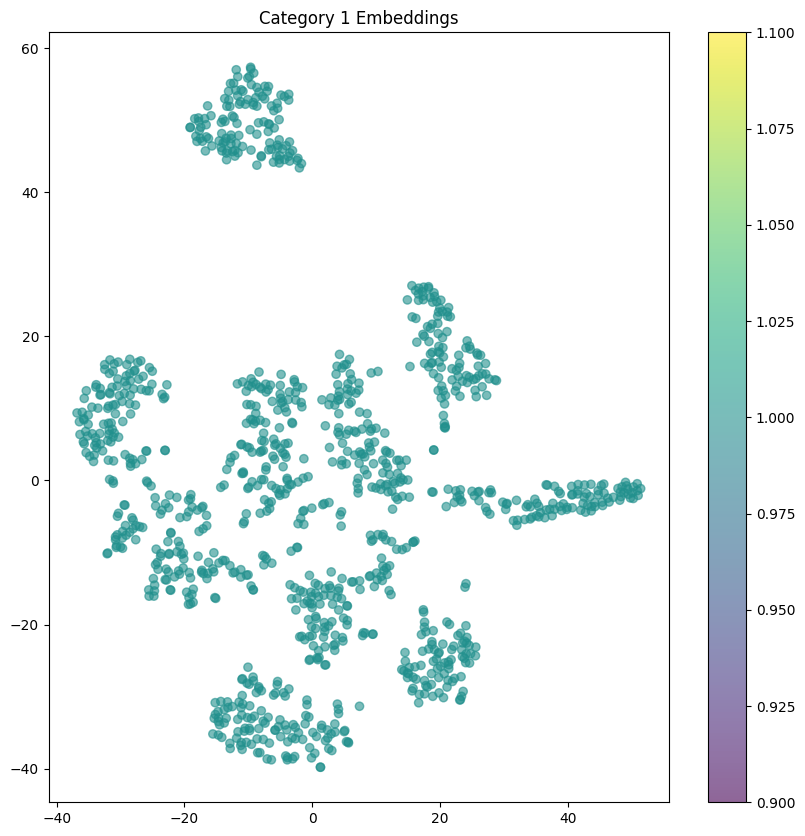

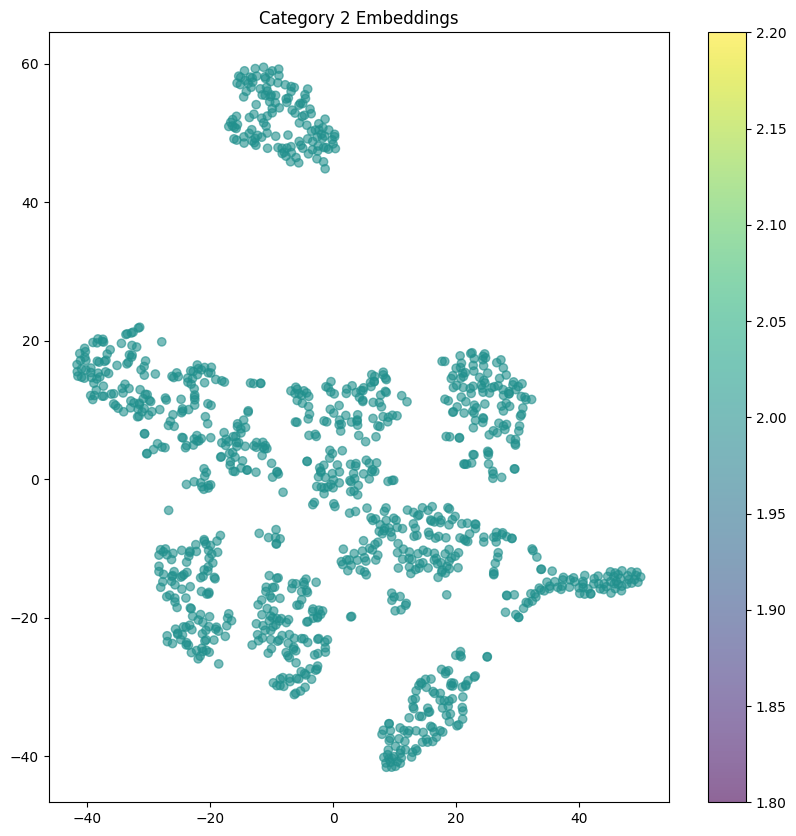

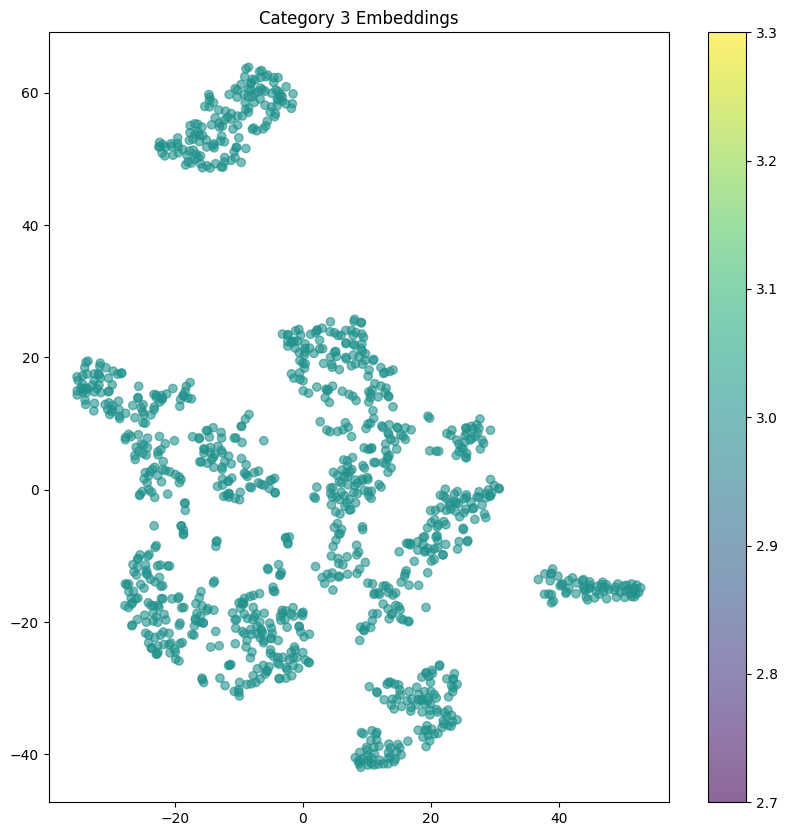

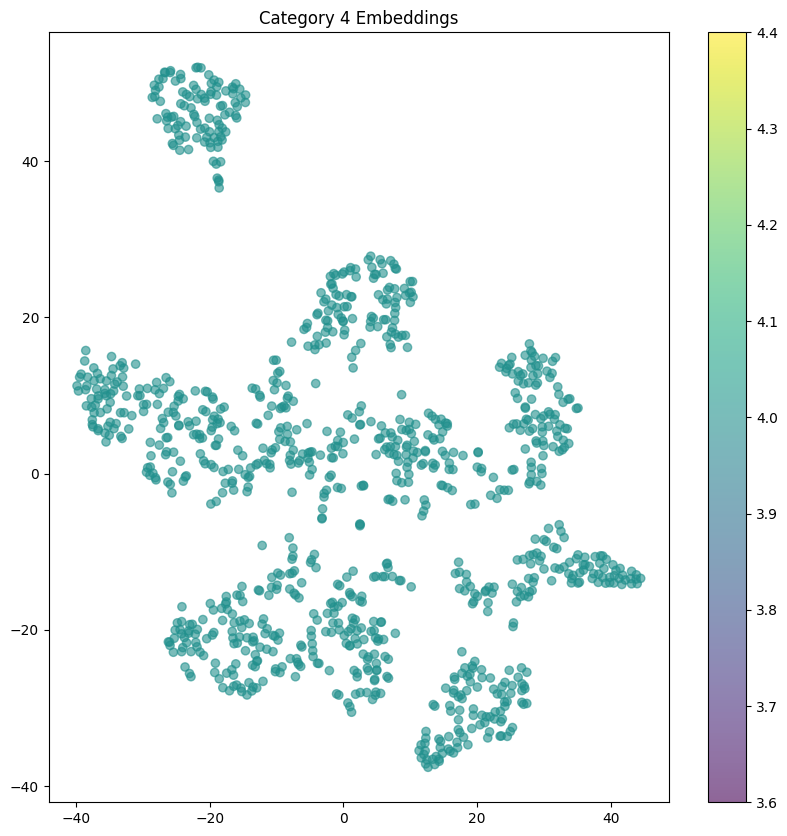

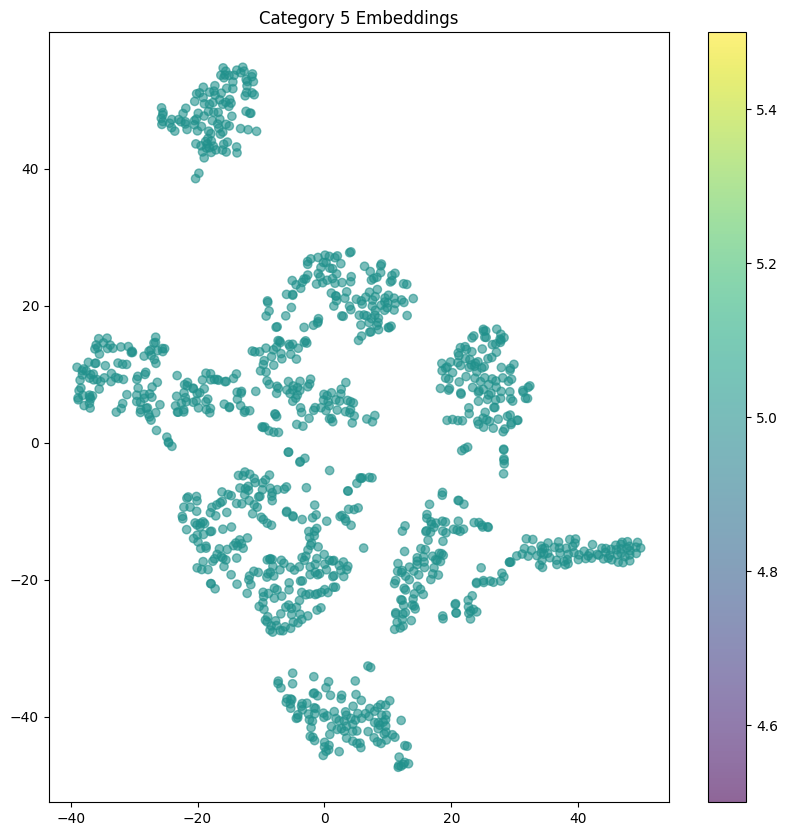

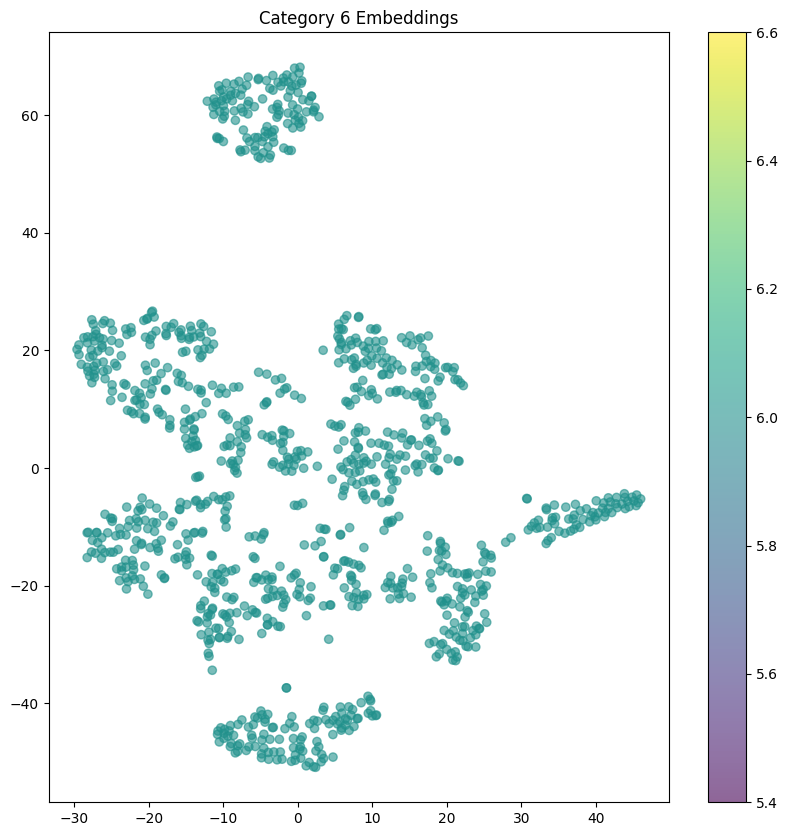

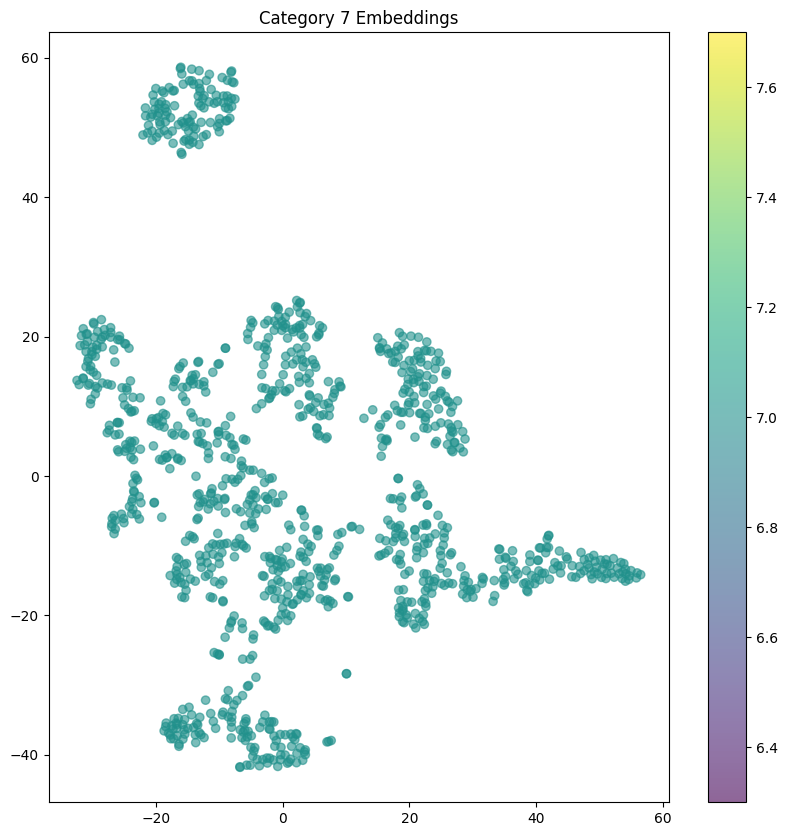

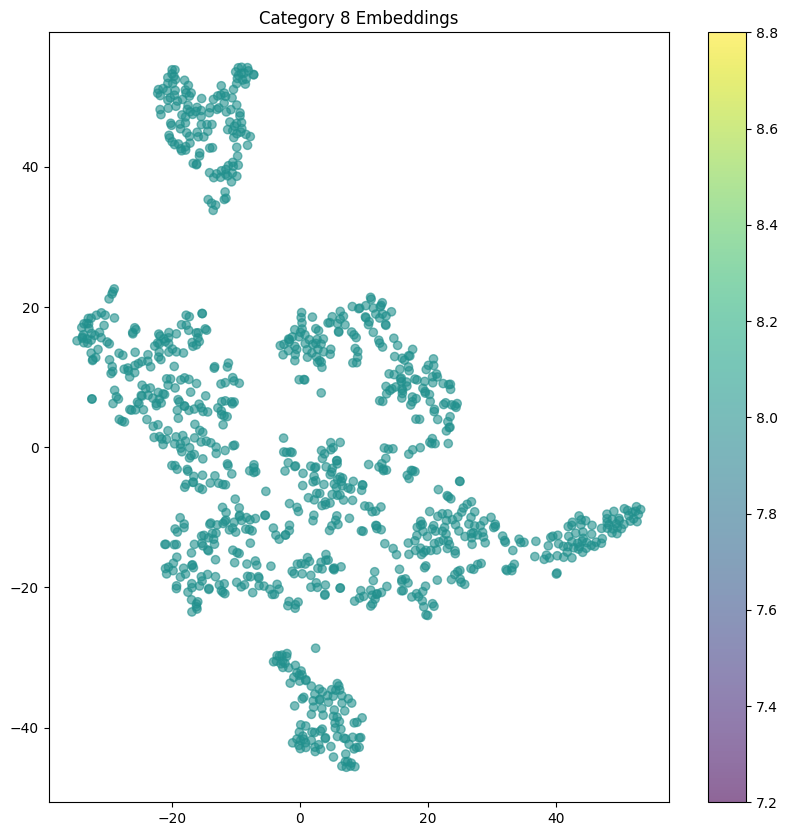

In [ ]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

def plot_embeddings(embeddings, labels, title):
    tsne = TSNE(n_components=2, random_state=42)
    reduced_embeddings = tsne.fit_transform(embeddings)

    plt.figure(figsize=(10, 10))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='viridis', alpha=0.6)
    plt.colorbar(scatter)
    plt.title(title)
    plt.show()

for category, embeddings in category_dict.items():
    if embeddings.size > 0:
        plot_embeddings(embeddings, np.full(embeddings.shape[0], category), f'Category {category} Embeddings')


In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()

In [ ]:
normalized_embs = []
list_embs = []
for category, embeddings in category_dict.items():
  list_embs.append(embeddings)
  normalized_embs.append(scaler.fit_transform(embeddings))

In [ ]:
normalized_embs[0].shape

(1114, 512)

In [ ]:
def plot_feature_cat(model, data, feature, results, step_angle):
    plt.figure(figsize=(12, 8))
    intervals = [f'{i*step_angle}-{(i+1)*step_angle}' for i in range(len(results))]
    plt.plot(intervals, results)
    plt.xlabel('Angles of rotation')
    plt.ylabel(f'{feature}')
    plt.title(f'{model} | {data} | {feature} for different categories of rotation')
    plt.show()

#### Persistence diagrams

In [ ]:
vrs = get_vr_diagrams(normalized_embs, maxdim=1)
vrs

[[array([[ 0.       ,  2.8955648],
         [ 0.       ,  3.0773098],
         [ 0.       ,  3.1344767],
         ...,
         [ 0.       , 27.962378 ],
         [ 0.       , 28.171358 ],
         [ 0.       , 28.332563 ]], dtype=float32),
  array([[33.517834 , 35.036907 ],
         [31.380926 , 32.232815 ],
         [30.361055 , 31.66896  ],
         ...,
         [ 6.5092316,  6.7385664],
         [ 6.4034843,  6.462921 ],
         [ 5.514426 ,  5.9268837]], dtype=float32)],
 [array([[ 0.       ,  2.4524517],
         [ 0.       ,  2.8897557],
         [ 0.       ,  3.4570653],
         ...,
         [ 0.       , 26.319187 ],
         [ 0.       , 26.675283 ],
         [ 0.       , 29.39583  ]], dtype=float32),
  array([[34.878338 , 36.123566 ],
         [31.611734 , 32.25171  ],
         [31.037956 , 33.161327 ],
         ...,
         [ 6.7884336,  6.977712 ],
         [ 6.2314477,  6.868961 ],
         [ 5.9090047,  6.5526204]], dtype=float32)],
 [array([[ 0.       ,  2.5356398],

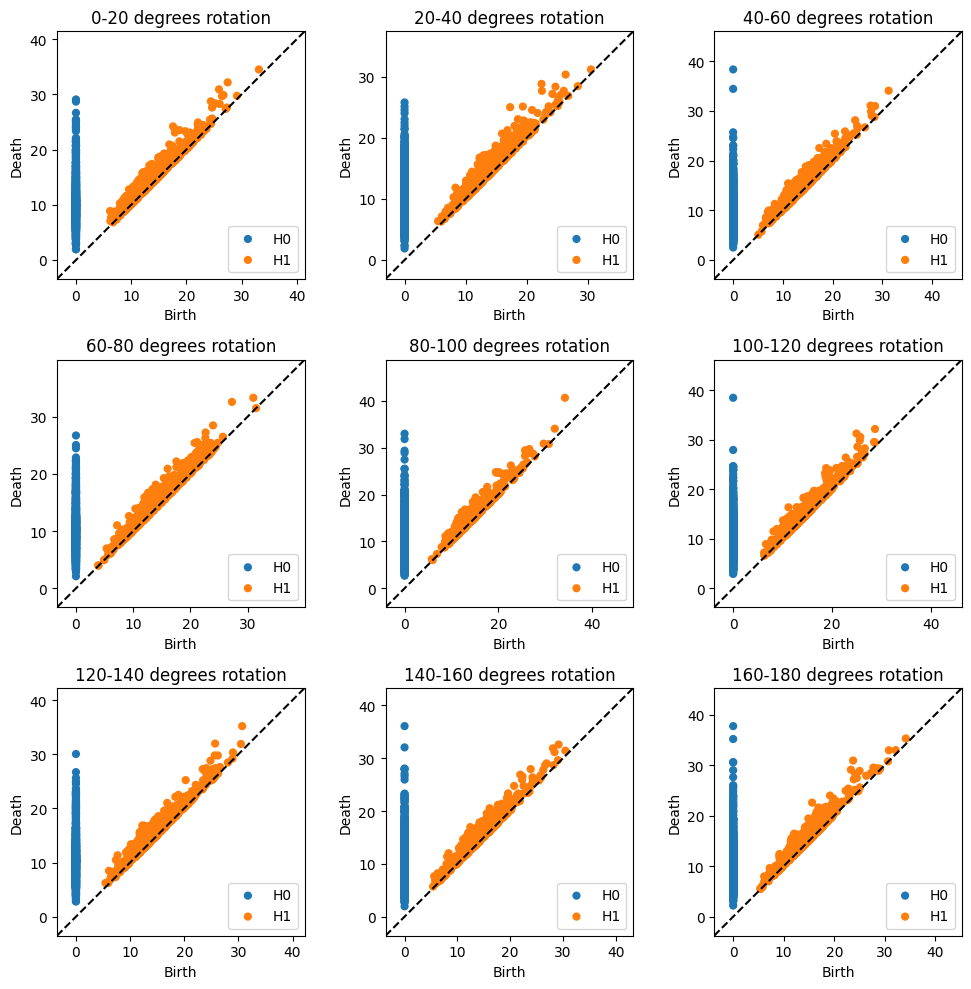

In [ ]:
num_diagrams = 9  # Number of diagrams to plot
fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # 3 rows, 3 columns

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each persistence diagram in a subplot
for i in range(num_diagrams):
    ax = axes[i]
    persim.plot_diagrams(vrs[i], labels=[f'H0', f'H1'], size=35, ax=ax)
    ax.set_title(f'{i*20}-{i*20+20} degrees rotation')

# Hide any empty subplots (if fewer than 6 diagrams)
for j in range(num_diagrams, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [ ]:
def get_vr_diagrams(normalized_embs, maxdim):
  vrs = []
  for i in range(len(normalized_embs)):
    vrs.append(drop_inf(vr_diagrams(normalized_embs[i], maxdim=maxdim)))
  return vrs

In [ ]:
vrs2 = get_vr_diagrams(normalized_embs, maxdim=2)

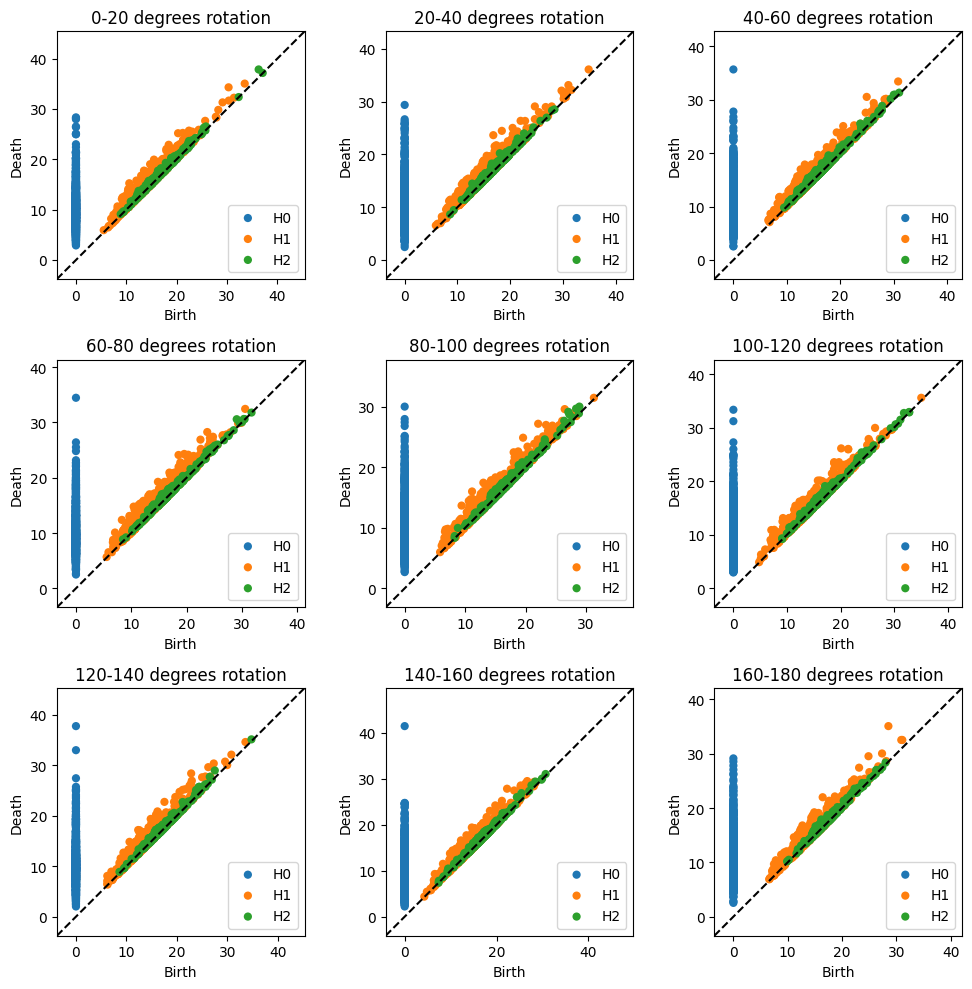

In [ ]:
num_diagrams = 9  # Number of diagrams to plot
fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # 3 rows, 3 columns

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Plot each persistence diagram in a subplot
for i in range(num_diagrams):
    ax = axes[i]
    persim.plot_diagrams(vrs2[i], labels=['H0', 'H1', 'H2'], size=35, ax=ax)
    ax.set_title(f'{i*20}-{i*20+20} degrees rotation')

# Hide any empty subplots (if fewer than 6 diagrams)
for j in range(num_diagrams, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### Total persistence

In [ ]:
total_persistences = []
for num_emb in range(len(vrs)):
  total_persistences.append(total_persistence(vrs[num_emb], q=0.5))
  print(f'Angle: {num_emb*20}-{num_emb*20+20} | Total persistence: {total_persistences[num_emb]}')

Angle: 0-20 | Total persistence: 4299.126953125
Angle: 20-40 | Total persistence: 4303.3134765625
Angle: 40-60 | Total persistence: 4482.6162109375
Angle: 60-80 | Total persistence: 4245.6240234375
Angle: 80-100 | Total persistence: 4396.2041015625
Angle: 100-120 | Total persistence: 4085.94140625
Angle: 120-140 | Total persistence: 4351.8486328125
Angle: 140-160 | Total persistence: 4248.525390625
Angle: 160-180 | Total persistence: 3937.455810546875


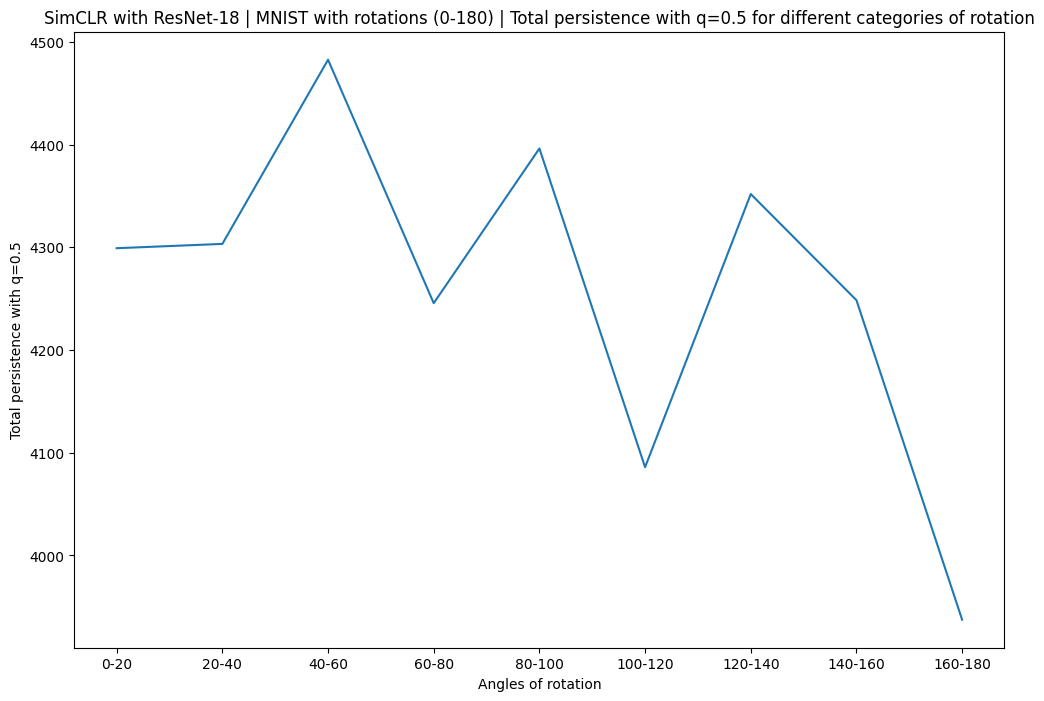

In [ ]:
plot_feature_cat(model="SimCLR with ResNet-18", data="MNIST with rotations (0-180)", feature='Total persistence with q=0.5', results=total_persistences, step_angle=20)

In [ ]:
total_persistences = []
for num_emb in range(len(vrs)):
  total_persistences.append(total_persistence(vrs[num_emb], q=1))
  print(f'Angle: {num_emb*20}-{num_emb*20+20} | Total persistence: {total_persistences[num_emb]}')

Angle: 0-20 | Total persistence: 12613.6171875
Angle: 20-40 | Total persistence: 12647.2197265625
Angle: 40-60 | Total persistence: 12970.50390625
Angle: 60-80 | Total persistence: 12372.5771484375
Angle: 80-100 | Total persistence: 12868.970703125
Angle: 100-120 | Total persistence: 11985.462890625
Angle: 120-140 | Total persistence: 12783.962890625
Angle: 140-160 | Total persistence: 12373.5107421875
Angle: 160-180 | Total persistence: 11848.3212890625


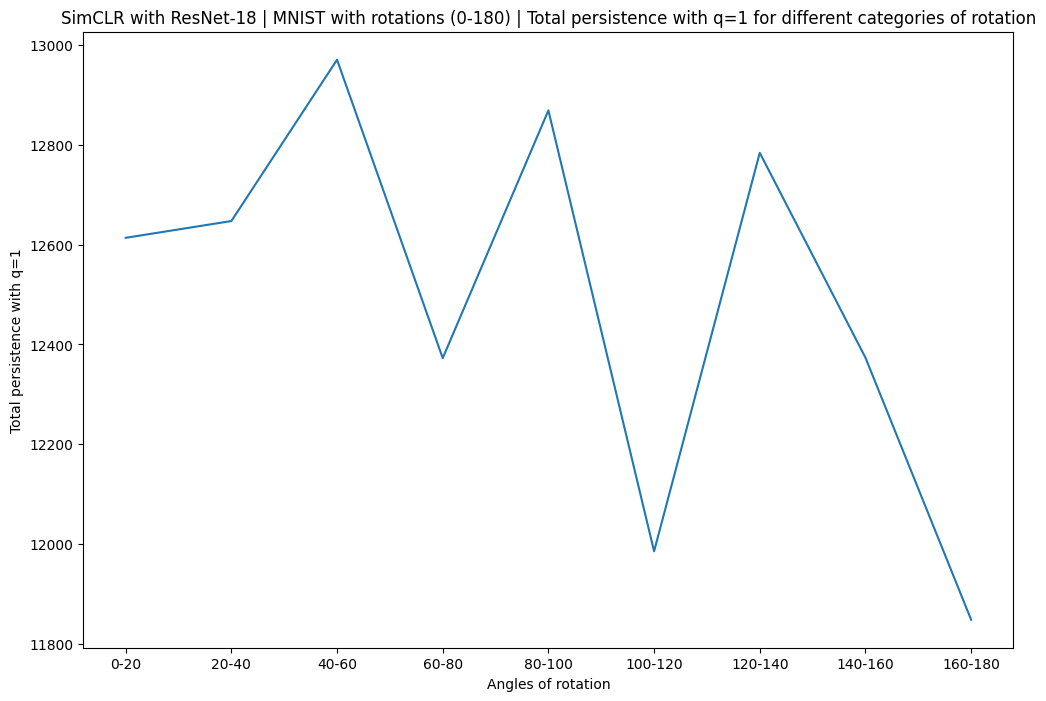

In [ ]:
plot_feature_cat(model="SimCLR with ResNet-18", data="MNIST with rotations (0-180)", feature='Total persistence with q=1', results=total_persistences, step_angle=20)

In [ ]:
total_persistence(vrs[-1], q=1)

11848.321

In [ ]:
persistence_norm(vrs[-1])

array([11108.70266724,   739.61831713])

#### Magnitudes

In [ ]:
reduced_embs = []

for embeddings in list_embs:
    reduced_embs.append(embeddings[:1000])

for i, reduced_embeddings in enumerate(reduced_embs):
    print(f"Category {i}, Reduced Embedding shape: {reduced_embeddings.shape}")

Category 0, Reduced Embedding shape: (1000, 512)
Category 1, Reduced Embedding shape: (1000, 512)
Category 2, Reduced Embedding shape: (1000, 512)
Category 3, Reduced Embedding shape: (1000, 512)
Category 4, Reduced Embedding shape: (1000, 512)
Category 5, Reduced Embedding shape: (1000, 512)
Category 6, Reduced Embedding shape: (1000, 512)
Category 7, Reduced Embedding shape: (1000, 512)
Category 8, Reduced Embedding shape: (1000, 512)


In [ ]:
magnitudes = []
for num_emb in range(len(reduced_embs)):
  magnitudes.append(magnitude(reduced_embs[num_emb]))

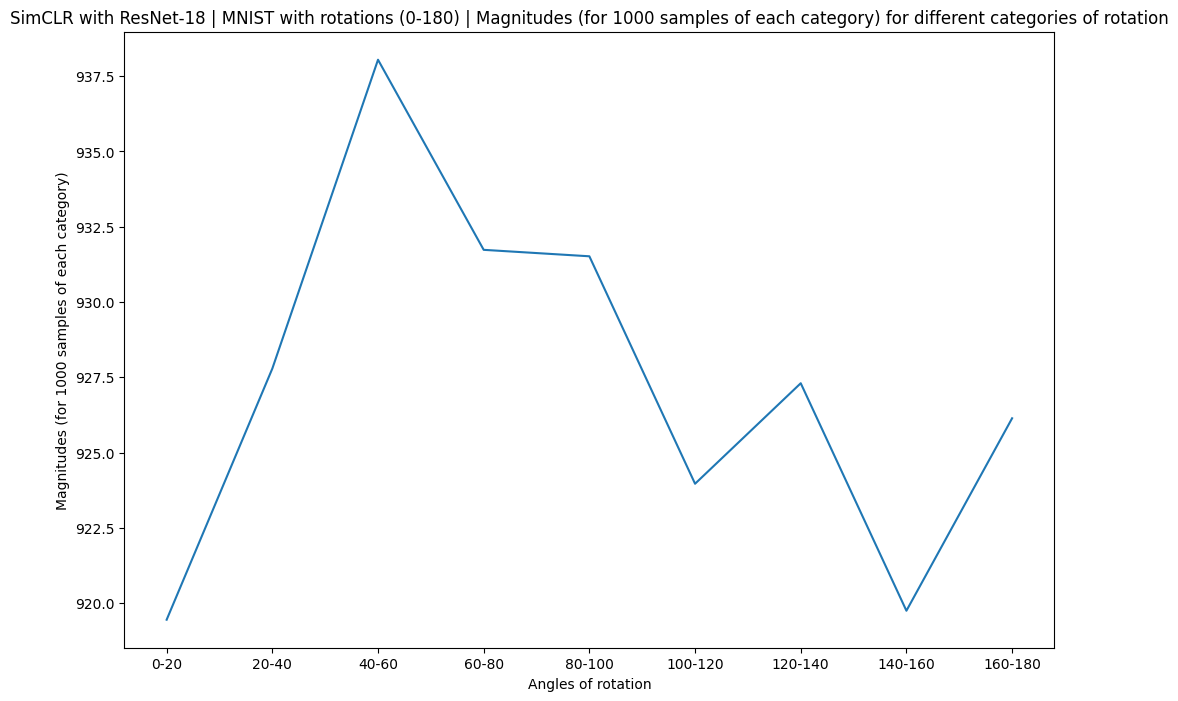

In [ ]:
plot_feature_cat(model="SimCLR with ResNet-18", data="MNIST with rotations (0-180)", feature='Magnitudes (for 1000 samples of each category)', results=magnitudes, step_angle=20)